In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pylab as plt

In [11]:
params = {"mathtext.default": "regular",
          "text.usetex": False,
          "figure.dpi": 300}          
plt.rcParams.update(params)

In [3]:
from pathlib import Path

corsika_data_file = "muon_spectrum/04_muon_spectrum"
corsika_data_file = f"{corsika_data_file}/04_sp_muon_run.h5"

dir_for_figures = Path("/hetghome/antonpr/xmax_sigma/flincpy/scripts/")
dir_for_figures = dir_for_figures/"plots/muon_sp/24_muon_run"

# Create path if it doesn't exist
Path(dir_for_figures).mkdir(parents=True, exist_ok=True)

# Fluka data load

In [4]:
from pathlib import Path
import sys

sys.path.insert(0, 
    "/hetghome/antonpr/xmax_sigma/flincpy/scripts/fluka_comparison")
from muon_shower_fluka import muon_shower_data
fluka_muon_shower = muon_shower_data()

# Corsika intializatioin

In [5]:
import sys
sys.path.append("/hetghome/antonpr/xmax_sigma/flincpy/scripts/corsika_flincpy")
from corsika_comparison_norm import (corsika_hist_en, combined_data_en, 
                                 corsika_en_theta_2dhist,
                                 combined_ang_data)

In [6]:
# Corsika energy distributions
# energy_bins = np.geomspace(1e-1, 1e3, 200)
energy_bins = fluka_muon_shower["mu"][0].en_bins
# energy_bins = mceq.e_bins
chist_en = corsika_hist_en(energy_bins, 
                           h5file=corsika_data_file)

04_sp_muon_run.h5: Number of primaries = 5.000000e+07


In [13]:
corsika_en_dist_mu = {}
corsika_en_dist_nue = {}
corsika_en_dist_numu = {}
for i in range(10):
    corsika_en_dist_mu[i]  = combined_data_en(chist_en, [13], i)
    corsika_en_dist_nue[i]  = combined_data_en(chist_en, [-12, 12], i)
    corsika_en_dist_numu[i]  = combined_data_en(chist_en, [-14, 14], i)


In [66]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(1,
                os.path.abspath('/hetghome/antonpr/MCEq'))
import numpy as np
import mceq_config as config
from MCEq.core import MCEqRun
from MCEq.geometry.density_profiles import GeneralizedTarget
import matplotlib.pyplot as plt
config.debug_level = 1
config.max_density = 1.293e-3 #0.001225
config.e_min = 1e-1
config.muon_helicity_dependence = False
config.average_loss_operator = False
config.enable_2D = False
config.mceq_db_fname = "/hetghome/antonpr/MCEq/MCEq/data/mceq_db_lext_dpm191_v150.h5"
target_grammage = 10000 # g/cm2
target = GeneralizedTarget(len_target=target_grammage/config.max_density, 
                           env_density=config.max_density, 
                           env_name='homogeneous air')
mceq = MCEqRun(interaction_model="DPMJETIII191", 
               theta_deg=None, 
               density_model=target, 
               primary_model=None)
print(f"Target max_X={target.max_X}," 
      f"target length={target.len_target/1e2:.2f} m")
from normalized_spectrum import NormalizedSpectrum
from normalized_spectrum import HistFromDist

muon_spectr = NormalizedSpectrum(pdg_id = 13,
                                 etot_min = 0.5, etot_max = 1000, 
                                 spectral_index = 3,
                                 number_particle_norm = 1)
muon_init_spectrum = muon_spectr.dN_dekin_mass0(mceq.e_grid)
mceq.set_initial_spectrum(muon_init_spectrum, 
                          pdg_id=13, append=False)

mceq_xdepths = [1, 10, 100, 300, 
                700, 1000, 3000, 
                5000, 7000, 10000]
mceq.solve(int_grid=mceq_xdepths)
mceq_sol = {}
particle_groups = [(13, "mu+", "mu-"),
                    (14, "numu", "antinumu"),
                    (12, "nue", "antinue"),
                    (211, "pi+", "pi-"),
                    (11, "e+", "e-")]

for pdg, *group in particle_groups:
    
    dist_xdepth = {}
    for ixdepth in range(len(mceq_xdepths)):
        dist = None
        for particle in group:
            if dist is None:
                dist = mceq.get_solution(particle, grid_idx = ixdepth)
            else:
                dist += mceq.get_solution(particle, grid_idx = ixdepth)
        dist_xdepth[ixdepth] = dist
    
    mceq_sol[pdg] = dist_xdepth           
mceq_sol_hist = {}
for pdg in mceq_sol:
    xdepth_hist = {}
    for ixdepth in mceq_sol[pdg]:
        hist = HistFromDist(mceq.e_grid, mceq_sol[pdg][ixdepth])
        bins, dN = hist.hist(energy_bins)
        xdepth_hist[ixdepth] = dN
    mceq_sol_hist[pdg] = xdepth_hist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
Target max_X=10000.0,target length=77339.52 m


Fraction = 9.98e-01
Fraction = 9.83e-01
Fraction = 8.24e-01
Fraction = 3.09e-01
Fraction = 5.37e-02
Fraction = 2.52e-02


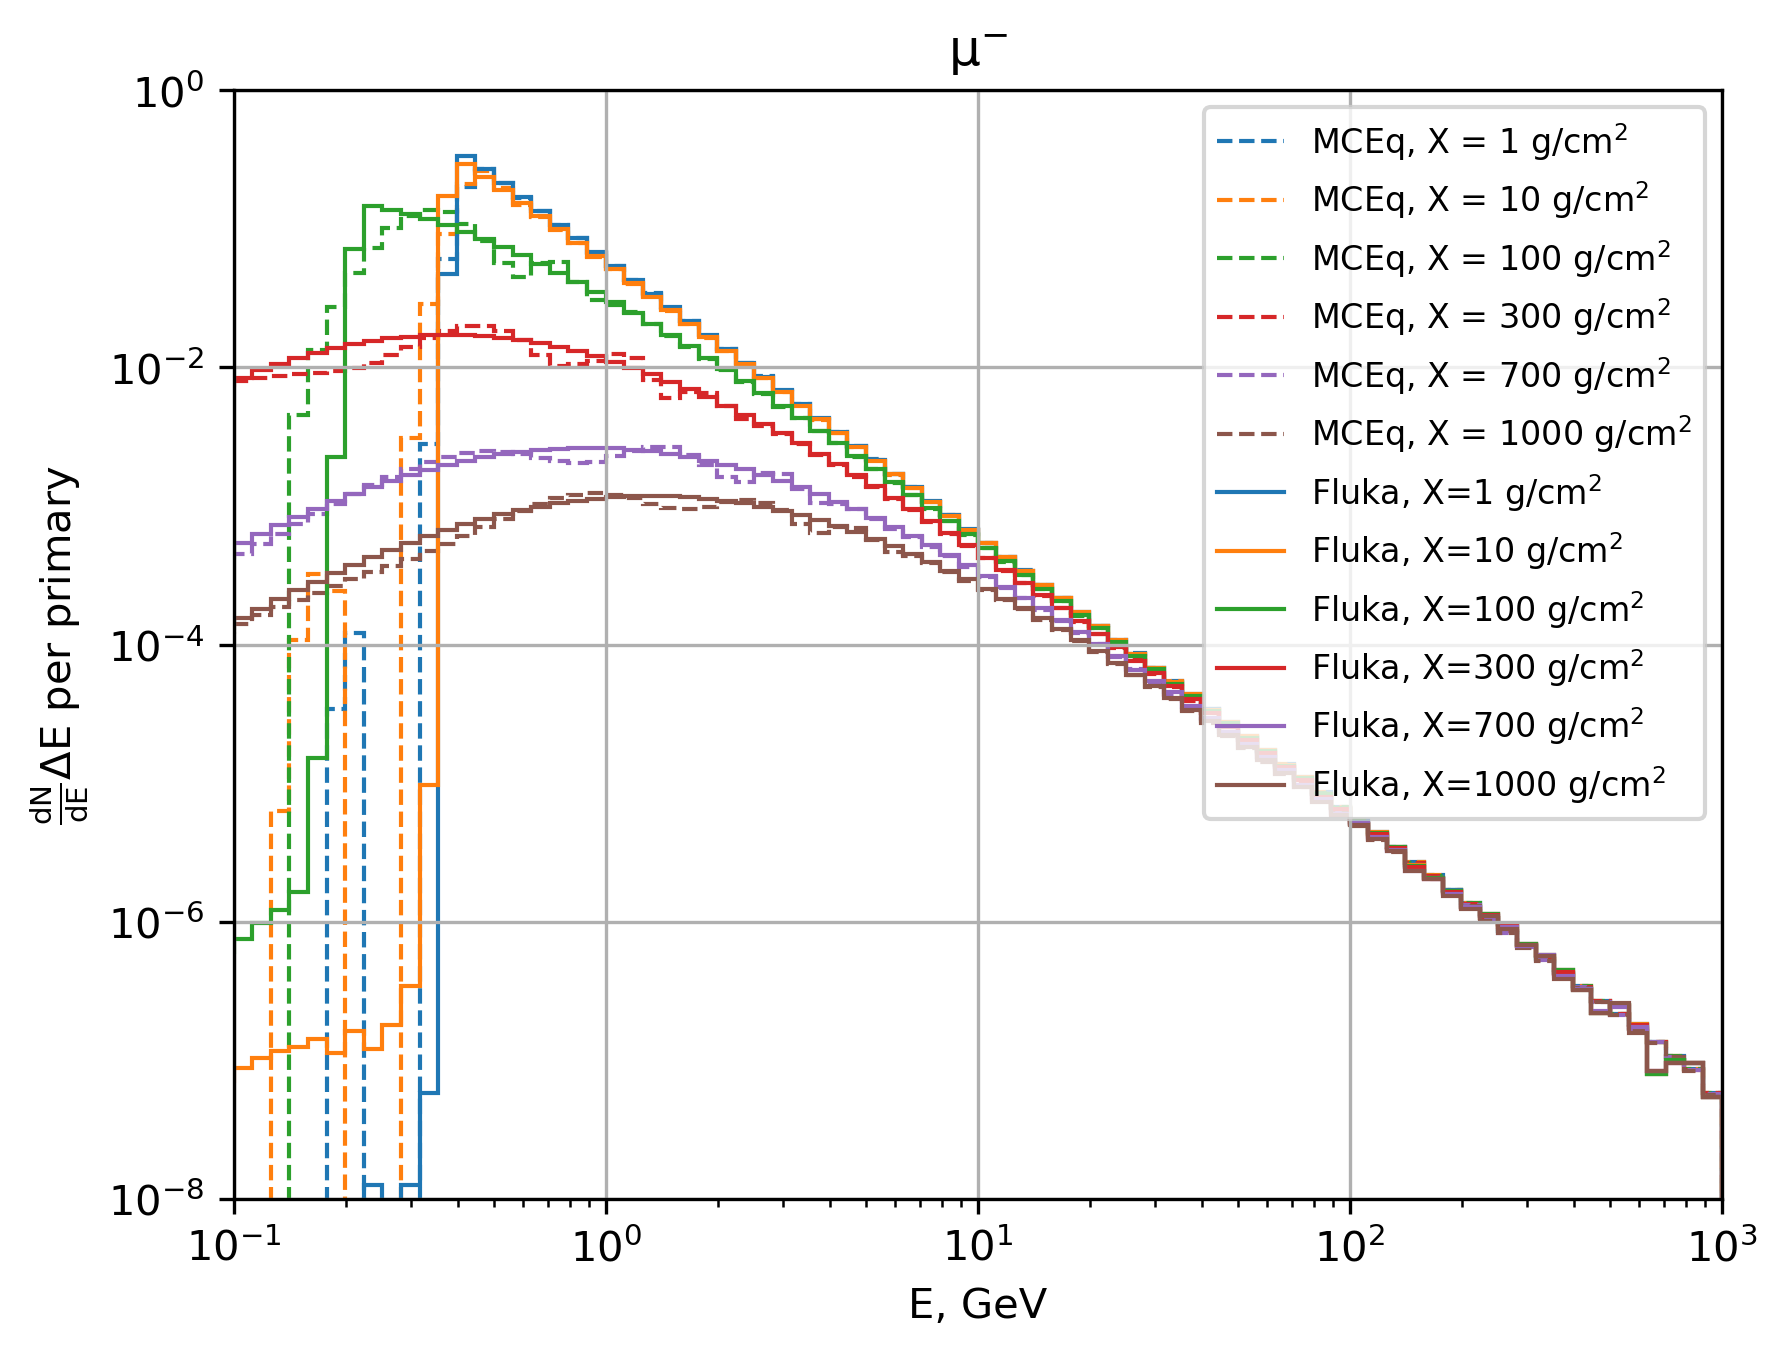

In [68]:
# figure_name = "fig_cm_03.svg"

# xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]


ax = plt.gca()
sigma = 1
# for ixdepth in range(3):    
#     fl_hist_en = corsika_en_dist[ixdepth]
#     num_primaries = fl_hist_en[4]
    
#     hist_dist = fl_hist_en[0]
#     tot_num = np.sum(hist_dist)
#     p_norm = hist_dist/tot_num
#     error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
#     fraction = tot_num/num_primaries
#     print(f"Fraction = {fraction:.2e}")
#     dist_to_plot = hist_dist/num_primaries
#     errors_to_plot = error_cors/num_primaries
#     bins_to_plot = fl_hist_en[1]
    
    
#     line = ax.stairs(dist_to_plot, bins_to_plot, 
#                     label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
#                     color = line_colors[ixdepth],
#                     linestyle = "-")
    
#     line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
#                     baseline = dist_to_plot-errors_to_plot, 
#                     fill=True,
#                     alpha = 0.2, 
#                     color = line_colors[ixdepth],
#                     linestyle = "-")
    
n_lines = len(mceq_xdepths)   
n_lines = 1
n_xdepths = [0, 1, 2, 3, 4, 5]
fluka_factor = 1.7
# n_xdepths = [0]
for ixdepth in n_xdepths:
    ax.stairs(mceq_sol_hist[13][ixdepth], energy_bins, 
               label = f"MCEq, X = {mceq_xdepths[ixdepth]} " + r"$g/cm^2$",
               color = line_colors[ixdepth],
               linestyle = "--") 


# ax.stairs(muon_spectr.dN_detot((energy_bins[1:] + energy_bins[:-1])/2) *
#           (energy_bins[1:] - energy_bins[:-1]), 
#             energy_bins, 
#             label = f"MCEq_init, X = {mceq_xdepths[ixdepth]} " + r"$g/cm^2$",
#             color = line_colors[ixdepth],
#             linestyle = "--") 
# ax.st(muon_spectr.dN_dekin((energy_bins[1:] + energy_bins[:-1])/2))
    
    
for ixdepth in n_xdepths:    
    # fl_hist_en = corsika_en_dist_munu[ixdepth]
    # num_primaries = fl_hist_en[4]
    
    # hist_dist = fl_hist_en[0]
    # tot_num = np.sum(hist_dist)
    # p_norm = hist_dist/tot_num
    # error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    # fraction = tot_num/num_primaries
    # print(f"Fraction = {fraction:.2e}")
    # dist_to_plot = hist_dist/num_primaries
    # errors_to_plot = error_cors/num_primaries
    # bins_to_plot = fl_hist_en[1]
    
    
    fluka_spect = fluka_muon_shower["mu"][ixdepth]
    line = ax.stairs(fluka_factor*fluka_spect.val *
                     (fluka_spect.en_bins[1:] - fluka_spect.en_bins[:-1])
                     , fluka_spect.en_bins, 
                label = f"Fluka, X={fluka_spect.xdepth} " 
                + r"$\mathrm{g}/\mathrm{cm}^2$",
                color = line_colors[ixdepth],
                linestyle = "-") 
    
    fl_hist_en = corsika_en_dist_mu[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    
    # line = ax.stairs(dist_to_plot, bins_to_plot, 
    #                 label = (f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$"),
    #                 color = line_colors[ixdepth],
    #                 linestyle = ":")
    
    # fluka_spect = fluka_muon_shower["mu"][ixdepth]
    # line = ax.stairs(fluka_spect.val
    #                  , fluka_spect.en_bins, 
    #             label = f"Fluka, X={fluka_spect.xdepth} " 
    #             + r"$\mathrm{g}/\mathrm{cm}^2$",
    #             color = line_colors[ixdepth],
    #             linestyle = "-")        
    
ax.set_title(r"$\mu^{-}$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_ylim(1e-8, 1e0)
ax.set_xlabel("E, GeV")

ax.set_yscale("log")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()          
# plt.savefig(dir_for_figures/figure_name)      

/tmp/ipykernel_855439/1220624898.py:62: RuntimeWarning: divide by zero encountered in divide
  ax.stairs(factor*fluka_h/mceq_sol_hist[13][ixdepth], energy_bins,
/tmp/ipykernel_855439/1220624898.py:62: RuntimeWarning: invalid value encountered in divide
  ax.stairs(factor*fluka_h/mceq_sol_hist[13][ixdepth], energy_bins,
/tmp/ipykernel_855439/1220624898.py:121: RuntimeWarning: divide by zero encountered in divide
  ax.stairs(factor*fluka_h/mceq_sol_hist[13][ixdepth], energy_bins,
/tmp/ipykernel_855439/1220624898.py:121: RuntimeWarning: invalid value encountered in divide
  ax.stairs(factor*fluka_h/mceq_sol_hist[13][ixdepth], energy_bins,


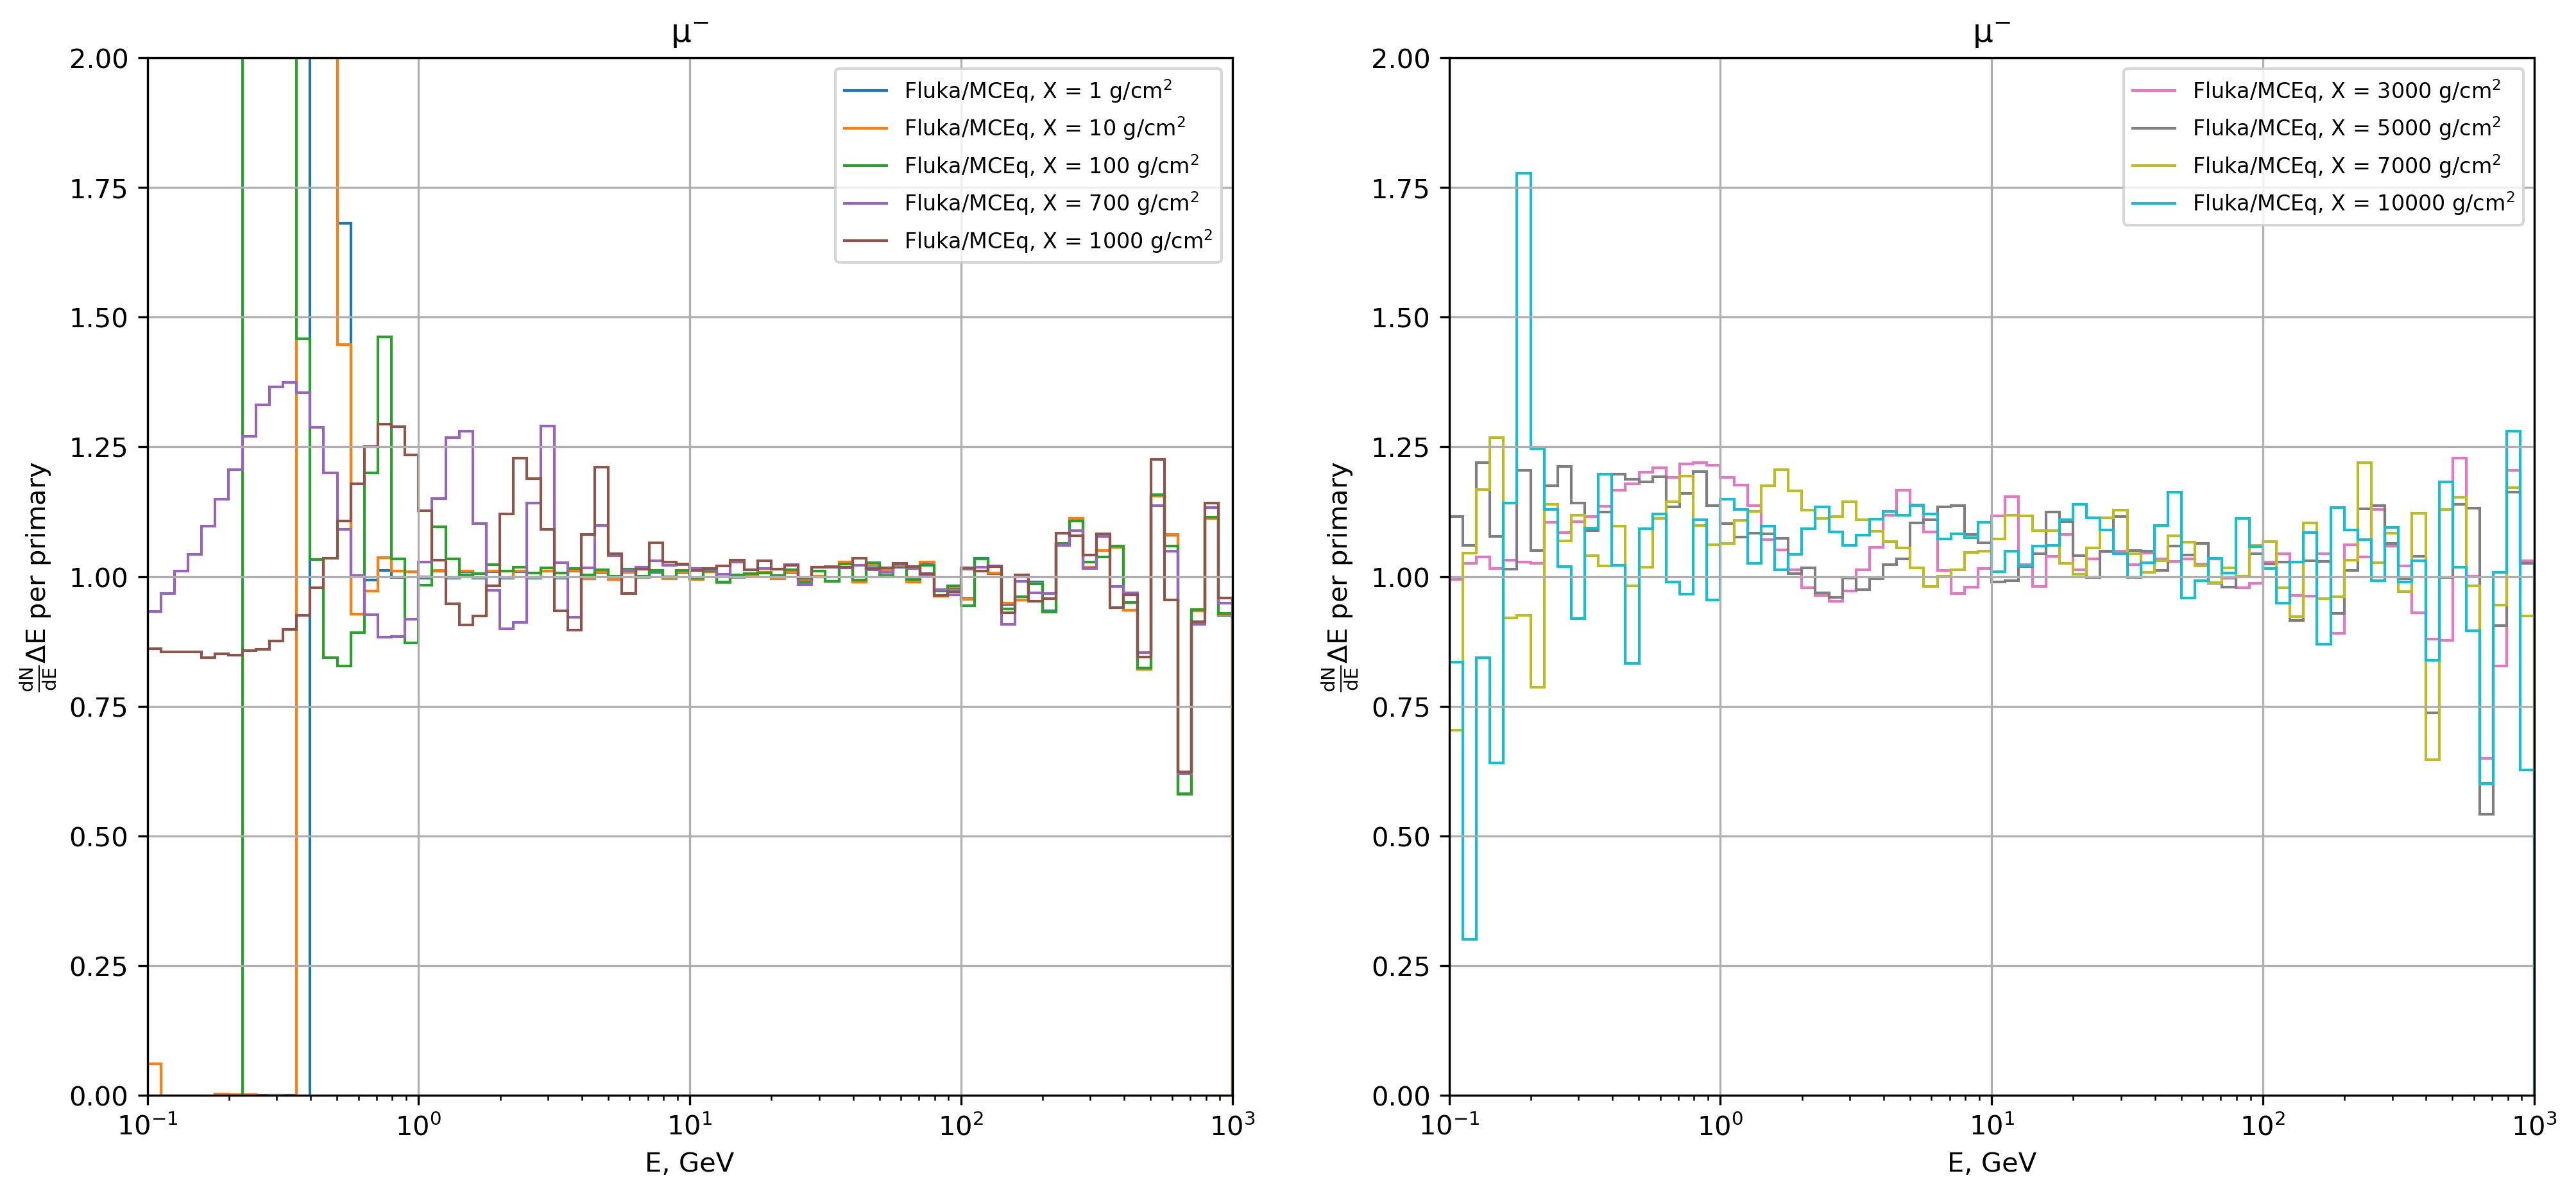

In [62]:
# figure_name = "fig_cm_03.svg"

figure = plt.figure(figsize=(16, 7))
grid_spec = figure.add_gridspec(nrows=1, 
                                ncols=2)

sigma = 1
axis = []
for i in range(1):
    axis_row = []
    for j in range(2):
        axis_row.append(figure.add_subplot(grid_spec[i, j]))
    axis.append(axis_row)

# xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]


# ax = plt.gca()
# sigma = 1
ax = axis[0][0]  
# for ixdepth in range(3):    
#     fl_hist_en = corsika_en_dist[ixdepth]
#     num_primaries = fl_hist_en[4]
    
#     hist_dist = fl_hist_en[0]
#     tot_num = np.sum(hist_dist)
#     p_norm = hist_dist/tot_num
#     error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
#     fraction = tot_num/num_primaries
#     print(f"Fraction = {fraction:.2e}")
#     dist_to_plot = hist_dist/num_primaries
#     errors_to_plot = error_cors/num_primaries
#     bins_to_plot = fl_hist_en[1]
    
    
#     line = ax.stairs(dist_to_plot, bins_to_plot, 
#                     label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
#                     color = line_colors[ixdepth],
#                     linestyle = "-")
    
#     line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
#                     baseline = dist_to_plot-errors_to_plot, 
#                     fill=True,
#                     alpha = 0.2, 
#                     color = line_colors[ixdepth],
#                     linestyle = "-")
    
n_lines = len(mceq_xdepths)   
n_lines = 1
n_xdepths = [0]
n_xdepths = [0, 1, 2, 4, 5]
factor = 1.7
for ixdepth in n_xdepths:
    
    fluka_spect = fluka_muon_shower["mu"][ixdepth]
    
    fluka_h = fluka_spect.val*(fluka_spect.en_bins[1:] - fluka_spect.en_bins[:-1])
    
    ax.stairs(factor*fluka_h/mceq_sol_hist[13][ixdepth], energy_bins, 
               label = f"Fluka/MCEq, X = {mceq_xdepths[ixdepth]} " + r"$g/cm^2$",
               color = line_colors[ixdepth],
               linestyle = "-") 
    
    
# for ixdepth in n_xdepths:    
#     # fl_hist_en = corsika_en_dist_munu[ixdepth]
#     # num_primaries = fl_hist_en[4]
    
#     # hist_dist = fl_hist_en[0]
#     # tot_num = np.sum(hist_dist)
#     # p_norm = hist_dist/tot_num
#     # error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
#     # fraction = tot_num/num_primaries
#     # print(f"Fraction = {fraction:.2e}")
#     # dist_to_plot = hist_dist/num_primaries
#     # errors_to_plot = error_cors/num_primaries
#     # bins_to_plot = fl_hist_en[1]
    
    
#     fluka_spect = fluka_muon_shower["mu"][ixdepth]
#     line = ax.stairs(1.3*fluka_spect.val *
#                      (fluka_spect.en_bins[1:] - fluka_spect.en_bins[:-1])
#                      , fluka_spect.en_bins, 
#                 label = f"Fluka, X={fluka_spect.xdepth} " 
#                 + r"$\mathrm{g}/\mathrm{cm}^2$",
#                 color = line_colors[ixdepth],
#                 linestyle = "-")       
    
ax.set_title(r"$\mu^{-}$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_ylim(0, 2e0)
ax.set_xlabel("E, GeV")

# ax.set_yscale("log")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()   


ax = axis[0][1]

    
n_lines = len(mceq_xdepths)   
n_lines = 1
n_xdepths = [0]
n_xdepths = range(len(mceq_xdepths))
n_xdepths = [6, 7, 8, 9]

for ixdepth in n_xdepths:
    
    fluka_spect = fluka_muon_shower["mu"][ixdepth]
    
    fluka_h = fluka_spect.val*(fluka_spect.en_bins[1:] - fluka_spect.en_bins[:-1])
    
    ax.stairs(factor*fluka_h/mceq_sol_hist[13][ixdepth], energy_bins, 
               label = f"Fluka/MCEq, X = {mceq_xdepths[ixdepth]} " + r"$g/cm^2$",
               color = line_colors[ixdepth],
               linestyle = "-") 
      
    
ax.set_title(r"$\mu^{-}$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_ylim(0, 2e0)
ax.set_xlabel("E, GeV")

# ax.set_yscale("log")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()    

Fraction = 9.98e-01
Fraction = 9.83e-01
Fraction = 8.24e-01
Fraction = 3.09e-01
Fraction = 5.37e-02
Fraction = 2.52e-02
Fraction = 2.36e-03
Fraction = 8.07e-04
Fraction = 3.98e-04
Fraction = 1.91e-04


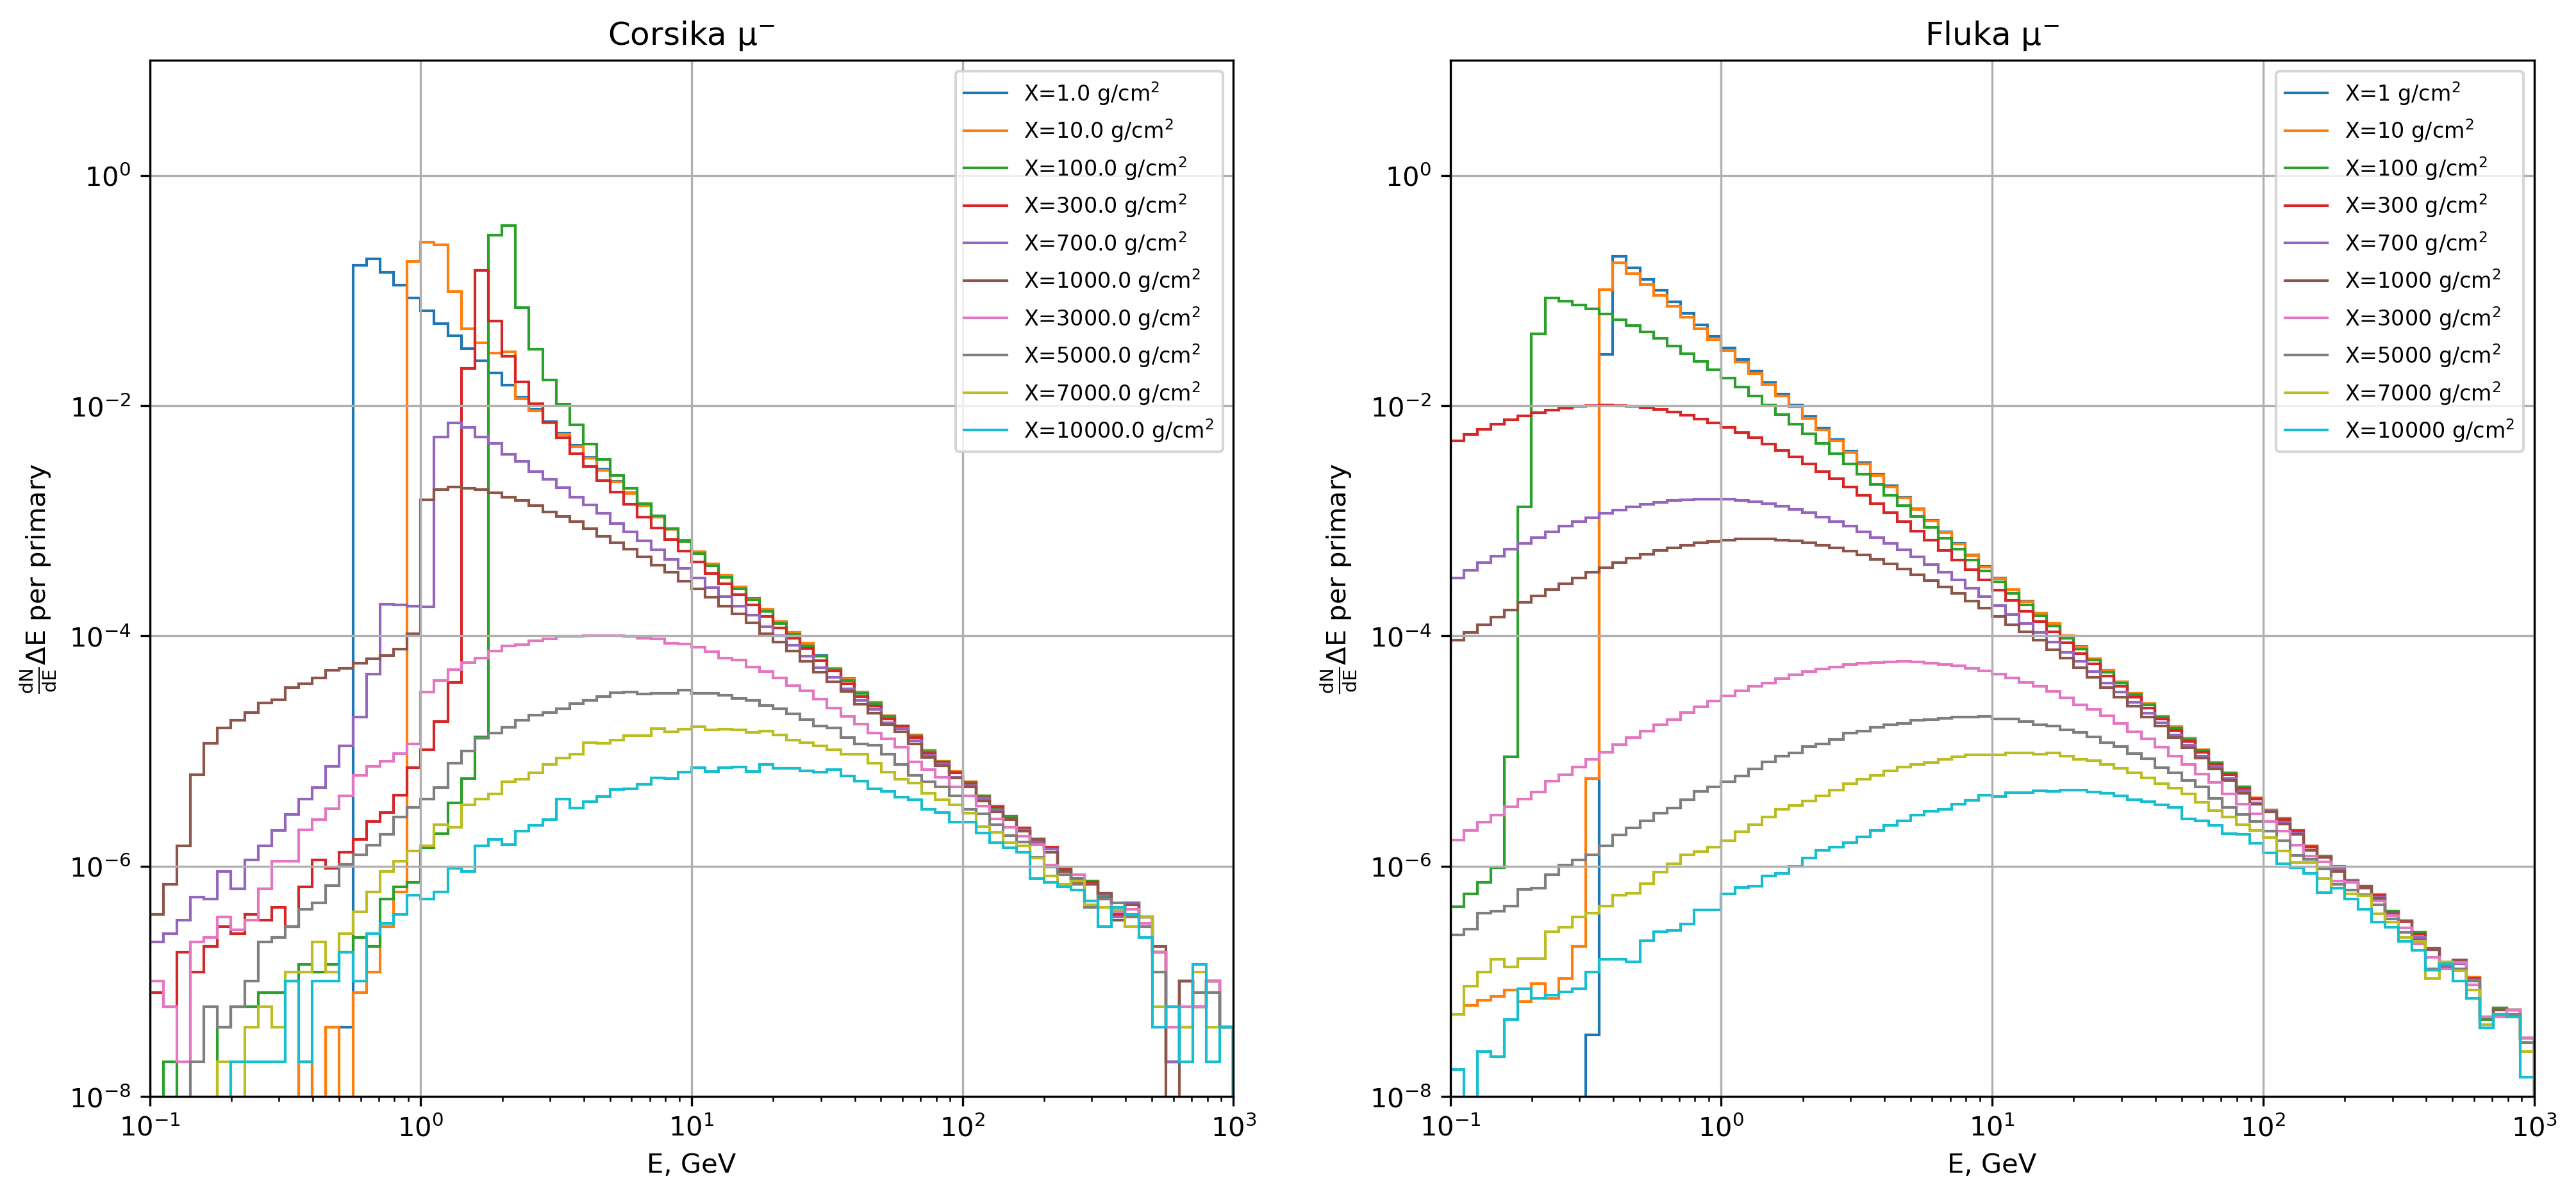

In [14]:
figure_name = "fig_cm_02.svg"
figure = plt.figure(figsize=(16, 7))
grid_spec = figure.add_gridspec(nrows=1, 
                                ncols=2)

sigma = 1
axis = []
for i in range(1):
    axis_row = []
    for j in range(2):
        axis_row.append(figure.add_subplot(grid_spec[i, j]))
    axis.append(axis_row)

ixdepth = 2
xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]

xdepth_num = 10
ax = axis[0][0]
for ixdepth in range(xdepth_num):  
    
    fl_hist_en = corsika_en_dist_mu[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    
    line = ax.stairs(dist_to_plot, bins_to_plot, 
                    label = (f"{fl_hist_en[3]} " + r"$g/cm^2$"),
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    # line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
    #                 baseline = dist_to_plot-errors_to_plot, 
    #                 fill=True,
    #                 alpha = 0.2, 
    #                 color = line_colors[ixdepth],
    #                 linestyle = "-")
    
    # fluka_spect = fluka_muon_shower["mu"][ixdepth]
    # line = ax.stairs(fluka_spect.val *
    #                  (fluka_spect.en_bins[1:] - fluka_spect.en_bins[:-1])
    #                  , fluka_spect.en_bins, 
    #             label = f"Fluka, X={fluka_spect.xdepth} " 
    #             + r"$\mathrm{g}/\mathrm{cm}^2$",
    #             color = line_colors[ixdepth],
    #             linestyle = "--")
    
    # line = ax.stairs(fluka_spect.en_bins[:-1]**(-3)*
    #                  (fluka_spect.en_bins[1:] - fluka_spect.en_bins[:-1]), 
    #                  fluka_spect.en_bins)
    
    
ax.set_title(r"Corsika $\mu^{-}$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_xlabel("E, GeV")

ax.set_yscale("log")
ax.set_ylim(1e-8, 1e1)
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# ax.set_ylim(0, 0.032)
ax.legend(fontsize="8")
# ax.grid()
# ax.grid(which = "both")
ax.grid()          

# Muon mu
ax = axis[0][1]
for ixdepth in range(xdepth_num):    
    # fl_hist_en = corsika_en_dist_munu[ixdepth]
    # num_primaries = fl_hist_en[4]
    
    # hist_dist = fl_hist_en[0]
    # tot_num = np.sum(hist_dist)
    # p_norm = hist_dist/tot_num
    # error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    # fraction = tot_num/num_primaries
    # print(f"Fraction = {fraction:.2e}")
    # dist_to_plot = hist_dist/num_primaries
    # errors_to_plot = error_cors/num_primaries
    # bins_to_plot = fl_hist_en[1]
    
    
    fluka_spect = fluka_muon_shower["mu"][ixdepth]
    line = ax.stairs(fluka_spect.val *
                     (fluka_spect.en_bins[1:] - fluka_spect.en_bins[:-1])
                     , fluka_spect.en_bins, 
                label = f"X={fluka_spect.xdepth} " 
                + r"$\mathrm{g}/\mathrm{cm}^2$",
                color = line_colors[ixdepth],
                linestyle = "-")
    
    
ax.set_title(r"Fluka $\mu^{-}$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_xlabel("E, GeV")

ax.set_yscale("log")
ax.set_ylim(1e-8, 1e1)
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# ax.set_ylim(0, 0.032)
ax.legend(fontsize="8")
ax.grid()   

# # Muon e
# ax = axis[0][2]
# for ixdepth in range(xdepth_num):    
#     fl_hist_en = corsika_en_dist_mue[ixdepth]
#     num_primaries = fl_hist_en[4]
    
#     hist_dist = fl_hist_en[0]
#     tot_num = np.sum(hist_dist)
#     p_norm = hist_dist/tot_num
#     error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
#     fraction = tot_num/num_primaries
#     print(f"Fraction = {fraction:.2e}")
#     dist_to_plot = hist_dist/num_primaries
#     errors_to_plot = error_cors/num_primaries
#     bins_to_plot = fl_hist_en[1]
    
    
#     line = ax.stairs(dist_to_plot, bins_to_plot, 
#                     label = (f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$, " +
#                              f"f={fraction:.2e}"),
#                     color = line_colors[ixdepth],
#                     linestyle = "-")
    
#     line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
#                     baseline = dist_to_plot-errors_to_plot, 
#                     fill=True,
#                     alpha = 0.2, 
#                     color = line_colors[ixdepth],
#                     linestyle = "-")
    
# ax.set_title(r"$\nu_e + \bar\nu_e$")

# ax.set_xscale("log")
# ax.set_xlim(1e-1, 1e3)
# ax.set_xlabel("E, GeV")

# ax.set_yscale("log")
# ax.set_ylim(1e-8, 1e1)
# ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
# # plt.yscale("log")
# # plt.xlim(0.08, 0.1)
# # ax.set_ylim(0, 0.032)
# ax.legend(fontsize="8")
# ax.grid()   



# figure.suptitle(r"Corsika energy distribution, primary "  + 
#             r"$\mu^{-}$, $E_{kin}=100$ GeV, $\theta=0^{\circ}$")

# figure.tight_layout()   
# plt.savefig(dir_for_figures/figure_name)   

Fraction = 9.98e-01
Fraction = 9.83e-01
Fraction = 8.24e-01


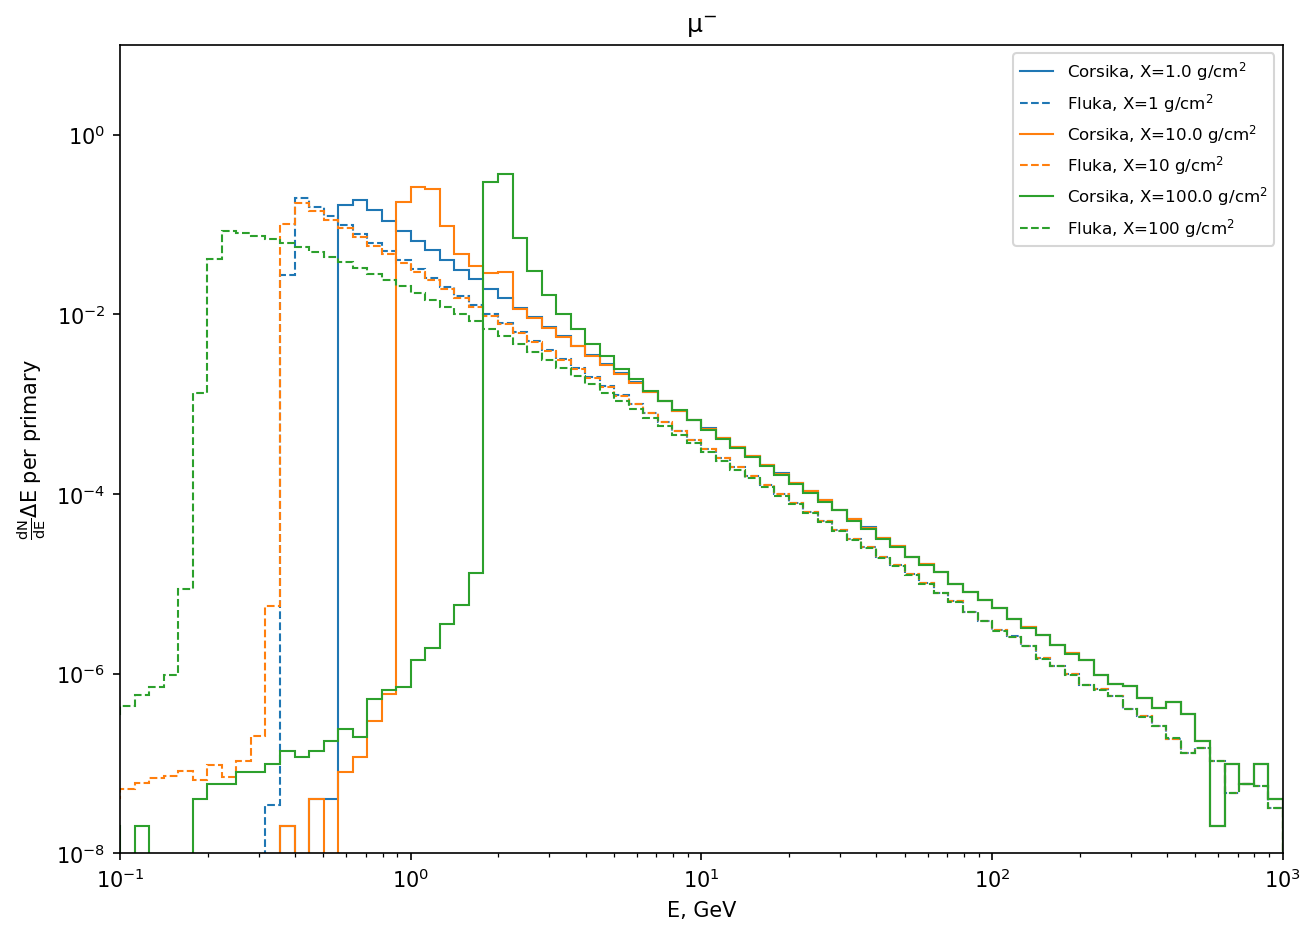

In [44]:
figure_name = "fig_cm_02.svg"
figure = plt.figure(figsize=(10, 7))
grid_spec = figure.add_gridspec(nrows=1, 
                                ncols=1)

sigma = 1
axis = []
for i in range(1):
    axis_row = []
    for j in range(1):
        axis_row.append(figure.add_subplot(grid_spec[i, j]))
    axis.append(axis_row)

ixdepth = 2
xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]

xdepth_num = 3
ax = axis[0][0]
for ixdepth in range(xdepth_num):  
    
    fl_hist_en = corsika_en_dist[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    
    line = ax.stairs(dist_to_plot, bins_to_plot, 
                    label = (f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$"),
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    # line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
    #                 baseline = dist_to_plot-errors_to_plot, 
    #                 fill=True,
    #                 alpha = 0.2, 
    #                 color = line_colors[ixdepth],
    #                 linestyle = "-")
    
    fluka_spect = fluka_muon_shower["mu"][ixdepth]
    line = ax.stairs(fluka_spect.val *
                     (fluka_spect.en_bins[1:] - fluka_spect.en_bins[:-1])
                     , fluka_spect.en_bins, 
                label = f"Fluka, X={fluka_spect.xdepth} " 
                + r"$\mathrm{g}/\mathrm{cm}^2$",
                color = line_colors[ixdepth],
                linestyle = "--")
    
    # line = ax.stairs(fluka_spect.en_bins[:-1]**(-3)*
    #                  (fluka_spect.en_bins[1:] - fluka_spect.en_bins[:-1]), 
    #                  fluka_spect.en_bins)
    
    
ax.set_title(r"$\mu^{-}$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_xlabel("E, GeV")

ax.set_yscale("log")
ax.set_ylim(1e-8, 1e1)
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# ax.set_ylim(0, 0.032)
ax.legend(fontsize="8")
# ax.grid()
# ax.grid(which = "both")          

# # Muon mu
# ax = axis[0][1]
# for ixdepth in range(xdepth_num):    
#     fl_hist_en = corsika_en_dist_munu[ixdepth]
#     num_primaries = fl_hist_en[4]
    
#     hist_dist = fl_hist_en[0]
#     tot_num = np.sum(hist_dist)
#     p_norm = hist_dist/tot_num
#     error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
#     fraction = tot_num/num_primaries
#     print(f"Fraction = {fraction:.2e}")
#     dist_to_plot = hist_dist/num_primaries
#     errors_to_plot = error_cors/num_primaries
#     bins_to_plot = fl_hist_en[1]
    
    
#     fluka_spect = fluka_muon_shower["mu"][ixdepth]
#     line = ax.stairs(fluka_spect.val *
#                      (fluka_spect.en_bins[1:] - fluka_spect.en_bins[:-1])
#                      , fluka_spect.en_bins, 
#                 label = f"Fluka, X={fluka_spect.xdepth} " 
#                 + r"$\mathrm{g}/\mathrm{cm}^2$",
#                 color = line_colors[ixdepth],
#                 linestyle = "--")
    
    
# ax.set_title(r"$\nu_{\mu} + \bar\nu_{\mu}$")

# ax.set_xscale("log")
# ax.set_xlim(1e-1, 1e3)
# ax.set_xlabel("E, GeV")

# ax.set_yscale("log")
# ax.set_ylim(1e-8, 1e1)
# ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
# # plt.yscale("log")
# # plt.xlim(0.08, 0.1)
# # ax.set_ylim(0, 0.032)
# ax.legend(fontsize="8")
# ax.grid()   

# # Muon e
# ax = axis[0][2]
# for ixdepth in range(xdepth_num):    
#     fl_hist_en = corsika_en_dist_mue[ixdepth]
#     num_primaries = fl_hist_en[4]
    
#     hist_dist = fl_hist_en[0]
#     tot_num = np.sum(hist_dist)
#     p_norm = hist_dist/tot_num
#     error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
#     fraction = tot_num/num_primaries
#     print(f"Fraction = {fraction:.2e}")
#     dist_to_plot = hist_dist/num_primaries
#     errors_to_plot = error_cors/num_primaries
#     bins_to_plot = fl_hist_en[1]
    
    
#     line = ax.stairs(dist_to_plot, bins_to_plot, 
#                     label = (f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$, " +
#                              f"f={fraction:.2e}"),
#                     color = line_colors[ixdepth],
#                     linestyle = "-")
    
#     line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
#                     baseline = dist_to_plot-errors_to_plot, 
#                     fill=True,
#                     alpha = 0.2, 
#                     color = line_colors[ixdepth],
#                     linestyle = "-")
    
# ax.set_title(r"$\nu_e + \bar\nu_e$")

# ax.set_xscale("log")
# ax.set_xlim(1e-1, 1e3)
# ax.set_xlabel("E, GeV")

# ax.set_yscale("log")
# ax.set_ylim(1e-8, 1e1)
# ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
# # plt.yscale("log")
# # plt.xlim(0.08, 0.1)
# # ax.set_ylim(0, 0.032)
# ax.legend(fontsize="8")
# ax.grid()   



# figure.suptitle(r"Corsika energy distribution, primary "  + 
#             r"$\mu^{-}$, $E_{kin}=100$ GeV, $\theta=0^{\circ}$")

# figure.tight_layout()   
# plt.savefig(dir_for_figures/figure_name)  

# Corsika angular distributions
### If needed it can be caluclated

In [30]:
# Corsika angular distributions
# energy_bins = [1, 1.25892541, 1.99526231,  2.51188643,  3.98107171, 5.01187234]
energy_bins_ang = [1, 1.3, 2, 2.5, 4, 5]
# ang_bins = fluka_ang_bins
ang_bins = np.deg2rad(np.linspace(0, 30, 61))
corsika_en_hist = corsika_en_theta_2dhist(energy_bins_ang, 
                                          ang_bins,
                                          h5file=corsika_data_file)

corsika_comb_mu = combined_ang_data(corsika_en_hist, (-13, 13))
corsika_comb_nue = combined_ang_data(corsika_en_hist, (-12, 12))
corsika_comb_numu = combined_ang_data(corsika_en_hist, (-14, 14))

pdg = -12
xdepth=1.0, number=6.4943e+04
xdepth=10.0, number=6.8712e+05
xdepth=100.0, number=7.8681e+06
xdepth=300.0, number=3.1200e+07
xdepth=700.0, number=4.2530e+07
xdepth=1000.0, number=4.3760e+07
xdepth=3000.0, number=4.4723e+07


KeyboardInterrupt: 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(1,
                os.path.abspath('/hetghome/antonpr/MCEq'))
import numpy as np
import mceq_config as config
from MCEq.core import MCEqRun
from MCEq.geometry.density_profiles import GeneralizedTarget
import matplotlib.pyplot as plt
config.debug_level = 1
config.max_density = 1.293e-3 #0.001225
config.e_min = 1e-1
config.muon_helicity_dependence = False
config.average_loss_operator = False
config.enable_2D = False
config.mceq_db_fname = "/hetghome/antonpr/MCEq/MCEq/data/mceq_db_lext_dpm191_v150.h5"
target_grammage = 10000 # g/cm2
target = GeneralizedTarget(len_target=target_grammage/config.max_density, 
                           env_density=config.max_density, 
                           env_name='homogeneous air')
mceq = MCEqRun(interaction_model="DPMJETIII191", 
               theta_deg=None, 
               density_model=target, 
               primary_model=None)
print(f"Target max_X={target.max_X}," 
      f"target length={target.len_target/1e2:.2f} m")
from normalized_spectrum import NormalizedSpectrum
from normalized_spectrum import HistFromDist

muon_spectr = NormalizedSpectrum(pdg_id = 13,
                                 etot_min = 0.5, etot_max = 1000, 
                                 spectral_index = 3,
                                 number_particle_norm = 1)
muon_init_spectrum = muon_spectr.dN_dekin(mceq.e_grid)
mceq.set_initial_spectrum(muon_init_spectrum, 
                          pdg_id=13, append=False)

mceq_xdepths = [1, 10, 100, 300, 
                700, 1000, 3000, 
                5000, 7000, 10000]
mceq.solve(int_grid=mceq_xdepths)
mceq_sol = {}
particle_groups = [(13, "mu+", "mu-"),
                    (14, "numu", "antinumu"),
                    (12, "nue", "antinue"),
                    (211, "pi+", "pi-"),
                    (11, "e+", "e-")]

for pdg, *group in particle_groups:
    
    dist_xdepth = {}
    for ixdepth in range(len(mceq_xdepths)):
        dist = None
        for particle in group:
            if dist is None:
                dist = mceq.get_solution(particle, grid_idx = ixdepth)
            else:
                dist += mceq.get_solution(particle, grid_idx = ixdepth)
        dist_xdepth[ixdepth] = dist
    
    mceq_sol[pdg] = dist_xdepth           
mceq_sol_hist = {}
for pdg in mceq_sol:
    xdepth_hist = {}
    for ixdepth in mceq_sol[pdg]:
        hist = HistFromDist(mceq.e_grid, mceq_sol[pdg][ixdepth])
        bins, dN = hist.hist(energy_bins)
        xdepth_hist[ixdepth] = dN
    mceq_sol_hist[pdg] = xdepth_hist

Fraction = 2.52e-02
Fraction = 7.95e-04
Fraction = 1.85e-04
Fraction = 8.84e-01
Fraction = 9.05e-01
Fraction = 9.05e-01
Fraction = 8.69e-01
Fraction = 8.90e-01
Fraction = 8.90e-01


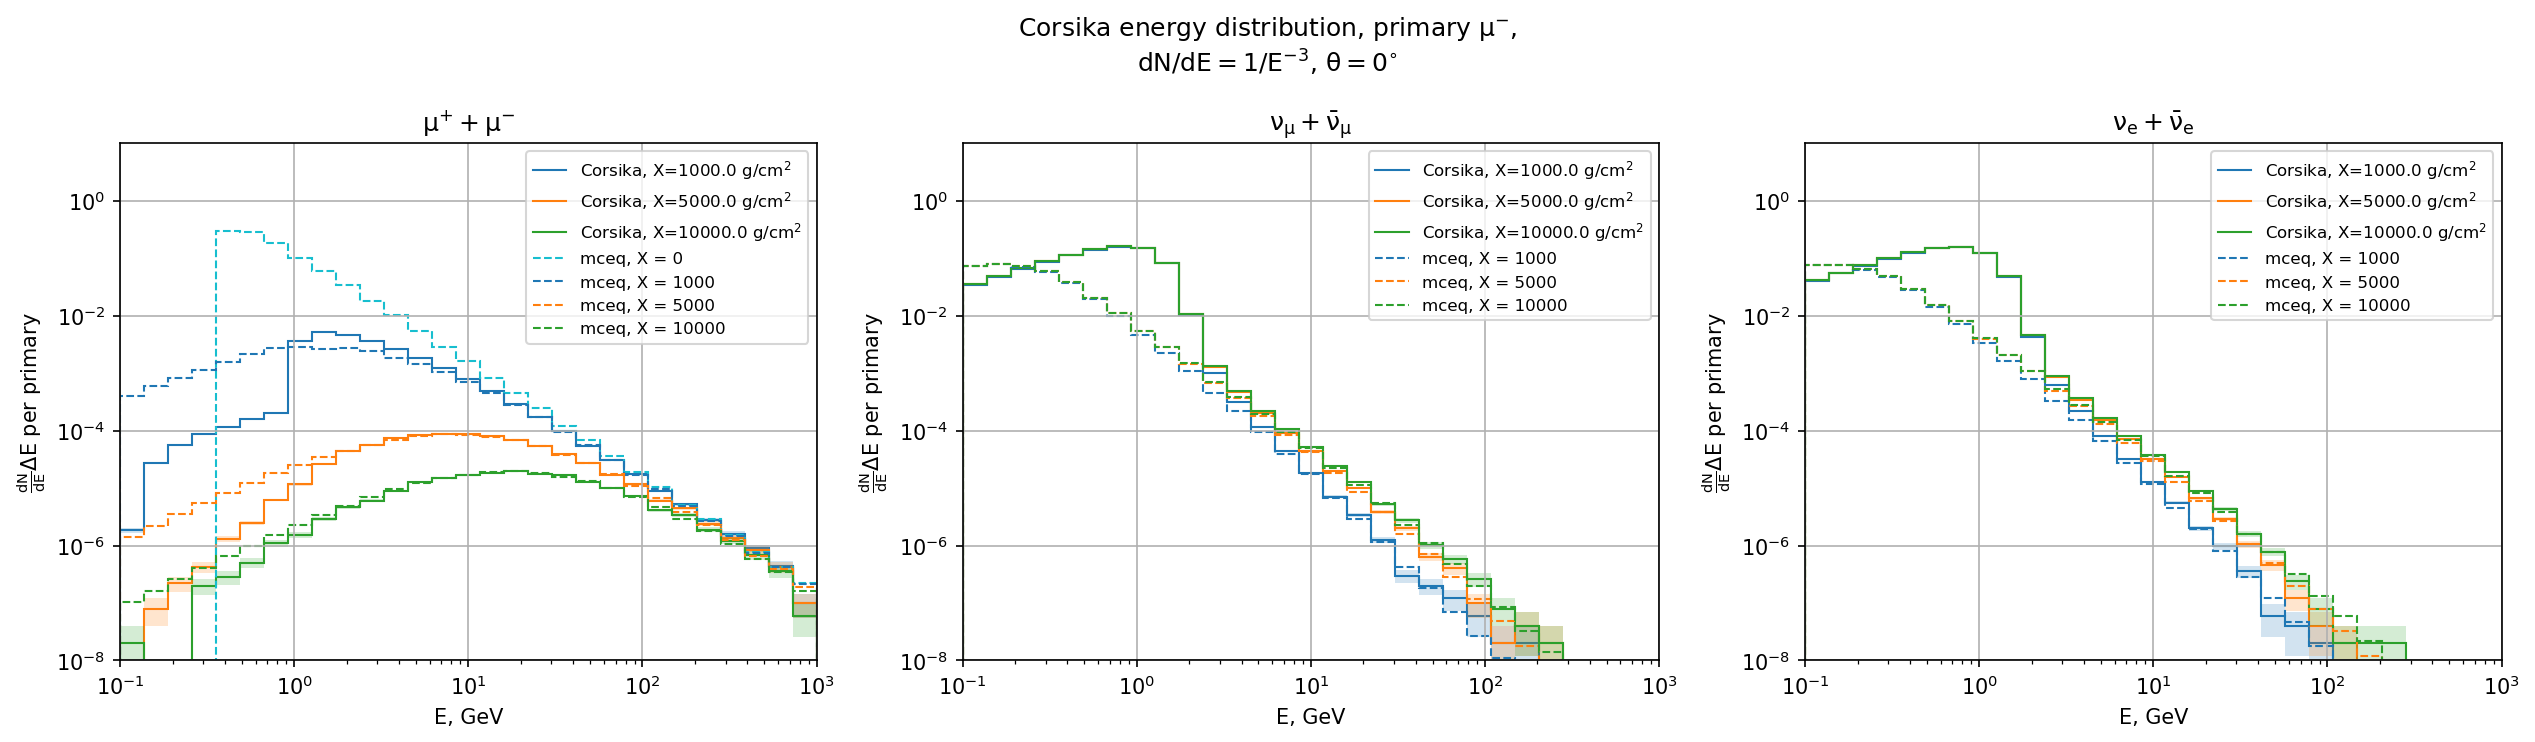

In [121]:
figure_name = "fig_cm_02.svg"
figure = plt.figure(figsize=(17, 5))
grid_spec = figure.add_gridspec(nrows=1, 
                                ncols=3, 
                                width_ratios=[1, 1, 1])

axis = []
for i in range(1):
    axis_row = []
    for j in range(3):
        axis_row.append(figure.add_subplot(grid_spec[i, j]))
    axis.append(axis_row)

ixdepth = 2
xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]

sigma = 1
ax = axis[0][0]
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    
    line = ax.stairs(dist_to_plot, bins_to_plot, 
                    label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
                    baseline = dist_to_plot-errors_to_plot, 
                    fill=True,
                    alpha = 0.2, 
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    
for ixdepth in range(len(mceq_xdepths)):
    ax.stairs(mceq_sol_hist[13][ixdepth], energy_bins, 
               label = f"mceq, X = {mceq_xdepths[ixdepth]}",
               color = line_colors[ixdepth - 1],
               linestyle = "--")    
    
ax.set_title(r"$\mu^{+} + \mu^{-}$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_ylim(1e-8, 1e1)
ax.set_xlabel("E, GeV")

ax.set_yscale("log")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()          

# Neutrino, mu_nu
ax = axis[0][1]
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist_munu[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    
    line = ax.stairs(dist_to_plot, bins_to_plot, 
                    label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
                    baseline = dist_to_plot-errors_to_plot, 
                    fill=True,
                    alpha = 0.2, 
                    color = line_colors[ixdepth],
                    linestyle = "-")

for ixdepth in range(len(mceq_xdepths)):
    if ixdepth == 0:
        continue
    ax.stairs(mceq_sol_hist[14][ixdepth], energy_bins, 
               label = f"mceq, X = {mceq_xdepths[ixdepth]}",
               color = line_colors[ixdepth - 1],
               linestyle = "--")      
    
    
ax.set_title(r"$\nu_{\mu} + \bar\nu_{\mu}$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_ylim(1e-8, 1e1)
ax.set_xlabel("E, GeV")

ax.set_yscale("log")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()   

# Neutrino, mu_e
ax = axis[0][2]
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist_mue[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    
    line = ax.stairs(dist_to_plot, bins_to_plot, 
                    label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
                    baseline = dist_to_plot-errors_to_plot, 
                    fill=True,
                    alpha = 0.2, 
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
for ixdepth in range(len(mceq_xdepths)):
    if ixdepth == 0:
        continue
    ax.stairs(mceq_sol_hist[12][ixdepth], energy_bins, 
               label = f"mceq, X = {mceq_xdepths[ixdepth]}",
               color = line_colors[ixdepth - 1],
               linestyle = "--")     
    
ax.set_title(r"$\nu_e + \bar\nu_e$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_ylim(1e-8, 1e1)
ax.set_xlabel("E, GeV")

ax.set_yscale("log")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()   



figure.suptitle(r"Corsika energy distribution, primary "  + 
            r"$\mu^{-}$," + "\n" +  r"$dN/dE=1/E^{-3}$, $\theta=0^{\circ}$")

figure.tight_layout()   
plt.savefig(dir_for_figures/figure_name) 

Fraction = 2.52e-02
Fraction = 7.95e-04
Fraction = 1.85e-04


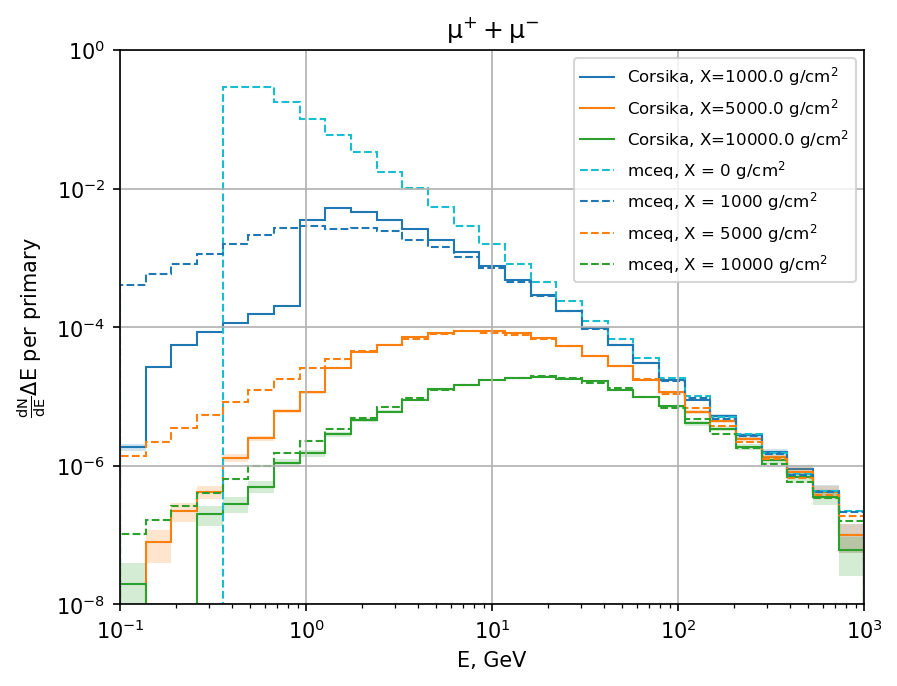

In [125]:
figure_name = "fig_cm_03.svg"

xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]


ax = plt.gca()
sigma = 1
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    
    line = ax.stairs(dist_to_plot, bins_to_plot, 
                    label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
                    baseline = dist_to_plot-errors_to_plot, 
                    fill=True,
                    alpha = 0.2, 
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    
for ixdepth in range(len(mceq_xdepths)):
    ax.stairs(mceq_sol_hist[13][ixdepth], energy_bins, 
               label = f"mceq, X = {mceq_xdepths[ixdepth]} " + r"$g/cm^2$",
               color = line_colors[ixdepth - 1],
               linestyle = "--")    
    
ax.set_title(r"$\mu^{+} + \mu^{-}$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_ylim(1e-8, 1e0)
ax.set_xlabel("E, GeV")

ax.set_yscale("log")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()          
plt.savefig(dir_for_figures/figure_name)       

Fraction = 2.52e-02
Fraction = 7.95e-04
Fraction = 1.85e-04


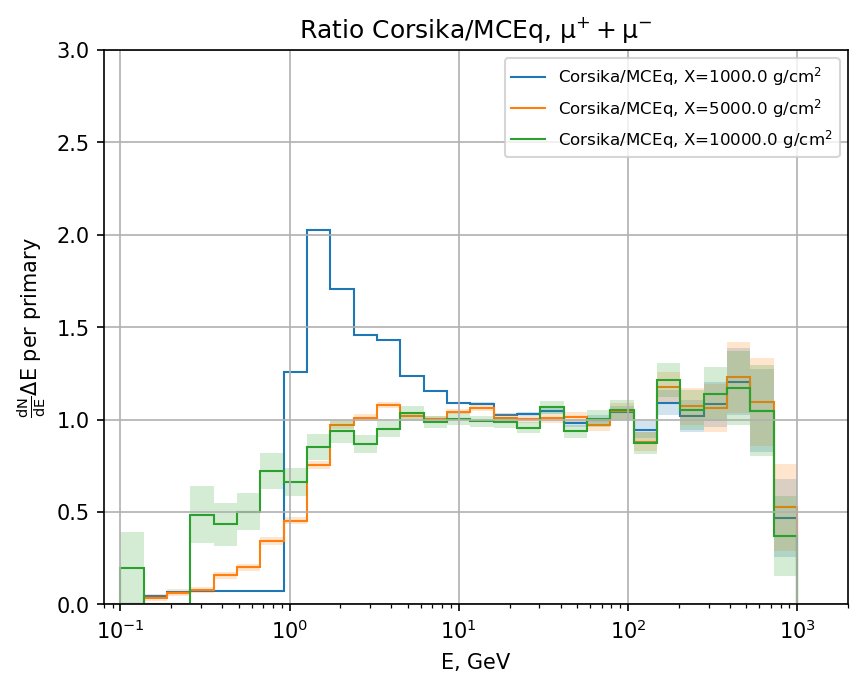

In [123]:
figure_name = "fig_cm_03_rat.svg"

xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]


ax = plt.gca()

sigma = 1
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    ratio = dist_to_plot/mceq_sol_hist[13][ixdepth + 1]
    ratio_errors = errors_to_plot/mceq_sol_hist[13][ixdepth + 1]
    line = ax.stairs(ratio, bins_to_plot, 
                    label = f"Corsika/MCEq, {fl_hist_en[3]} " + r"$g/cm^2$",
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    line = ax.stairs(ratio+ratio_errors, bins_to_plot, 
                    baseline = ratio-ratio_errors, 
                    fill=True,
                    alpha = 0.2, 
                    color = line_colors[ixdepth],
                    linestyle = "-")

ax.set_title("Ratio Corsika/MCEq, " + r"$\mu^{+} + \mu^{-}$")

ax.set_xscale("log")
ax.set_xlim(8e-2, 2e3)
ax.set_ylim(0, 3)
ax.set_xlabel(r"$E$, GeV")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()
plt.savefig(dir_for_figures/figure_name)     

Fraction = 8.84e-01
Fraction = 9.05e-01
Fraction = 9.05e-01


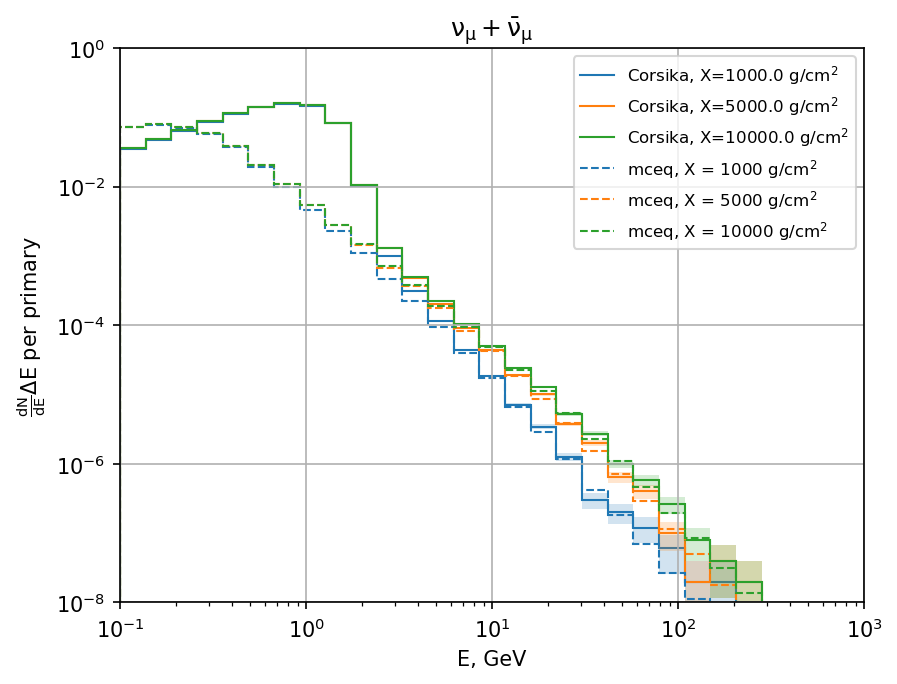

In [126]:
figure_name = "fig_cm_04.svg"

xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]


ax = plt.gca()
sigma = 1
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist_munu[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    
    line = ax.stairs(dist_to_plot, bins_to_plot, 
                    label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
                    baseline = dist_to_plot-errors_to_plot, 
                    fill=True,
                    alpha = 0.2, 
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    
for ixdepth in range(len(mceq_xdepths)):
    if ixdepth == 0:
        continue
    ax.stairs(mceq_sol_hist[14][ixdepth], energy_bins, 
               label = f"mceq, X = {mceq_xdepths[ixdepth]} " + r"$g/cm^2$",
               color = line_colors[ixdepth - 1],
               linestyle = "--")    
    
ax.set_title(r"$\nu_{\mu} + \bar\nu_{\mu}$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_ylim(1e-8, 1e0)
ax.set_xlabel("E, GeV")

ax.set_yscale("log")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()      
    
plt.savefig(dir_for_figures/figure_name)

Fraction = 8.84e-01
Fraction = 9.05e-01
Fraction = 9.05e-01


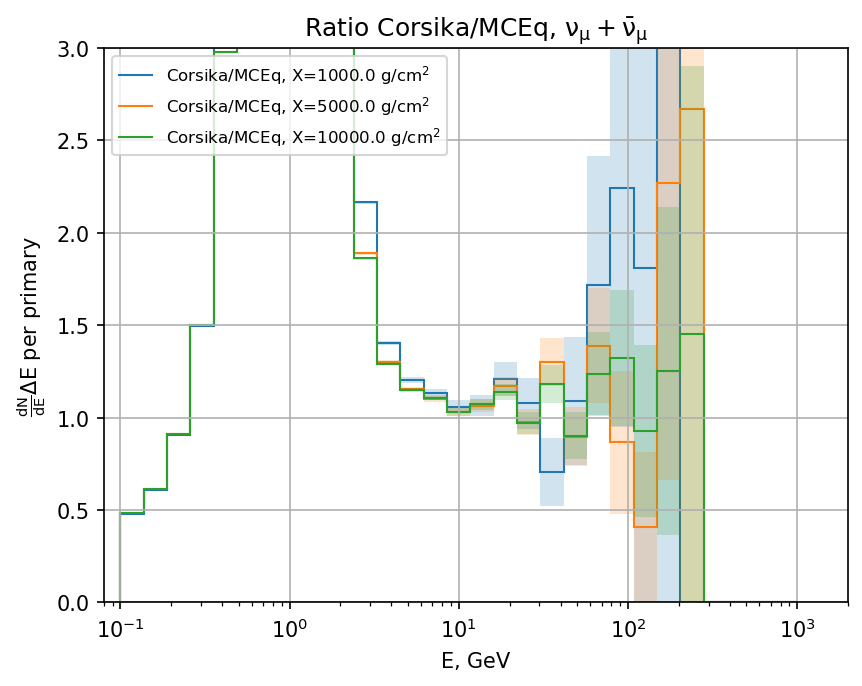

In [127]:
figure_name = "fig_cm_04_rat.svg"

xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]


ax = plt.gca()

sigma = 1
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist_munu[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    ratio = dist_to_plot/mceq_sol_hist[14][ixdepth + 1]
    ratio_errors = errors_to_plot/mceq_sol_hist[14][ixdepth + 1]
    line = ax.stairs(ratio, bins_to_plot, 
                    label = f"Corsika/MCEq, {fl_hist_en[3]} " + r"$g/cm^2$",
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    line = ax.stairs(ratio+ratio_errors, bins_to_plot, 
                    baseline = ratio-ratio_errors, 
                    fill=True,
                    alpha = 0.2, 
                    color = line_colors[ixdepth],
                    linestyle = "-")

ax.set_title("Ratio Corsika/MCEq, " + r"$\nu_{\mu} + \bar\nu_{\mu}$")

ax.set_xscale("log")
ax.set_xlim(8e-2, 2e3)
ax.set_ylim(0, 3)
ax.set_xlabel(r"$E$, GeV")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()
plt.savefig(dir_for_figures/figure_name)   

Fraction = 8.69e-01
Fraction = 8.90e-01
Fraction = 8.90e-01


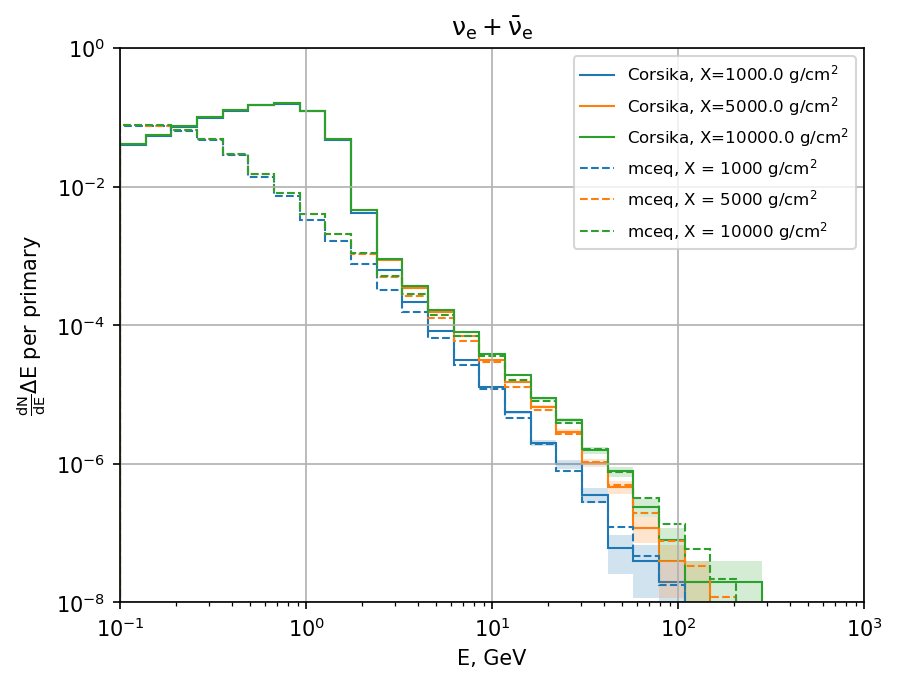

In [128]:
figure_name = "fig_cm_05.svg"

xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]


ax = plt.gca()
sigma = 1
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist_mue[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    
    line = ax.stairs(dist_to_plot, bins_to_plot, 
                    label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    line = ax.stairs(dist_to_plot+errors_to_plot, bins_to_plot, 
                    baseline = dist_to_plot-errors_to_plot, 
                    fill=True,
                    alpha = 0.2, 
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    
for ixdepth in range(len(mceq_xdepths)):
    if ixdepth == 0:
        continue
    ax.stairs(mceq_sol_hist[12][ixdepth], energy_bins, 
               label = f"mceq, X = {mceq_xdepths[ixdepth]} " + r"$g/cm^2$",
               color = line_colors[ixdepth - 1],
               linestyle = "--")    
    
ax.set_title(r"$\nu_{e} + \bar\nu_{e}$")

ax.set_xscale("log")
ax.set_xlim(1e-1, 1e3)
ax.set_ylim(1e-8, 1e0)
ax.set_xlabel("E, GeV")

ax.set_yscale("log")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()      
plt.savefig(dir_for_figures/figure_name)

Fraction = 8.69e-01
Fraction = 8.90e-01
Fraction = 8.90e-01


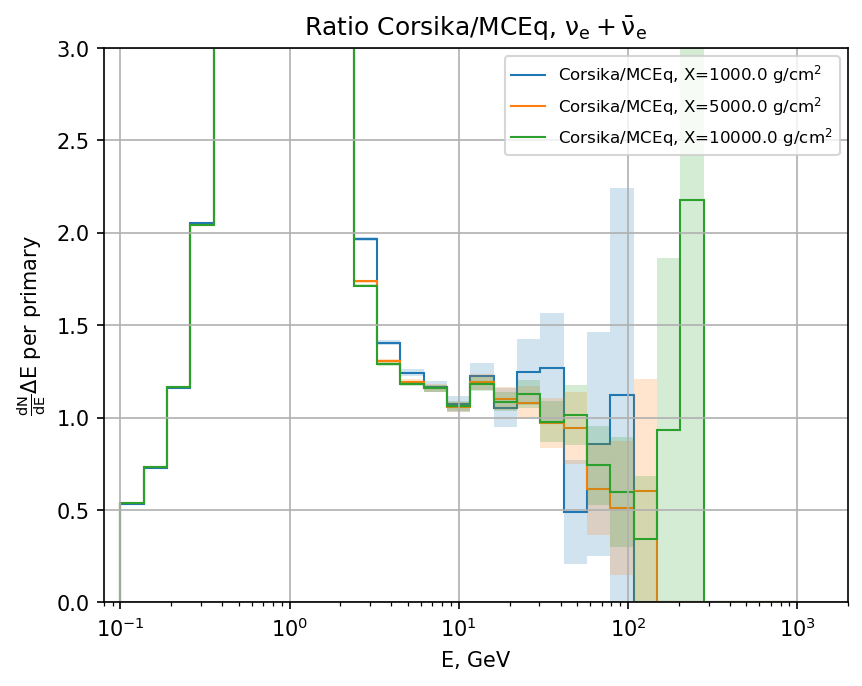

In [129]:
figure_name = "fig_cm_05_rat.svg"

xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]


ax = plt.gca()

sigma = 1
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist_mue[ixdepth]
    num_primaries = fl_hist_en[4]
    
    hist_dist = fl_hist_en[0]
    tot_num = np.sum(hist_dist)
    p_norm = hist_dist/tot_num
    error_cors = sigma*np.sqrt(p_norm*(1-p_norm)*tot_num)
    
    fraction = tot_num/num_primaries
    print(f"Fraction = {fraction:.2e}")
    dist_to_plot = hist_dist/num_primaries
    errors_to_plot = error_cors/num_primaries
    bins_to_plot = fl_hist_en[1]
    
    ratio = dist_to_plot/mceq_sol_hist[12][ixdepth + 1]
    ratio_errors = errors_to_plot/mceq_sol_hist[12][ixdepth + 1]
    line = ax.stairs(ratio, bins_to_plot, 
                    label = f"Corsika/MCEq, {fl_hist_en[3]} " + r"$g/cm^2$",
                    color = line_colors[ixdepth],
                    linestyle = "-")
    
    line = ax.stairs(ratio+ratio_errors, bins_to_plot, 
                    baseline = ratio-ratio_errors, 
                    fill=True,
                    alpha = 0.2, 
                    color = line_colors[ixdepth],
                    linestyle = "-")

ax.set_title("Ratio Corsika/MCEq, " + r"$\nu_{e} + \bar\nu_{e}$")

ax.set_xscale("log")
ax.set_xlim(8e-2, 2e3)
ax.set_ylim(0, 3)
ax.set_xlabel(r"$E$, GeV")
ax.set_ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
ax.legend(fontsize="8")
ax.grid()
plt.savefig(dir_for_figures/figure_name)   

In [ ]:
dEdX = (np.trapz(mceq.get_solution("mu-", mag=0) * mceq.e_grid, mceq.e_grid)/np.trapz(mceq.get_solution("mu-", mag=0), mceq.e_grid) - Emu)/target.max_X
print(dEdX)
plt.plot(mceq.e_grid, mceq.get_solution("mu-", mag=0)* mceq.e_grid)
plt.plot(mceq.e_grid, muon_sp_grid * mceq.e_grid)
plt.xscale("log")
plt.xlim(1e0, 1e5)
plt.yscale("log")
plt.ylim(1e-6)

# Corsika_MTrue vs Corsika_MFalse angular distributions

NameError: name 'corsika_comb_mu' is not defined

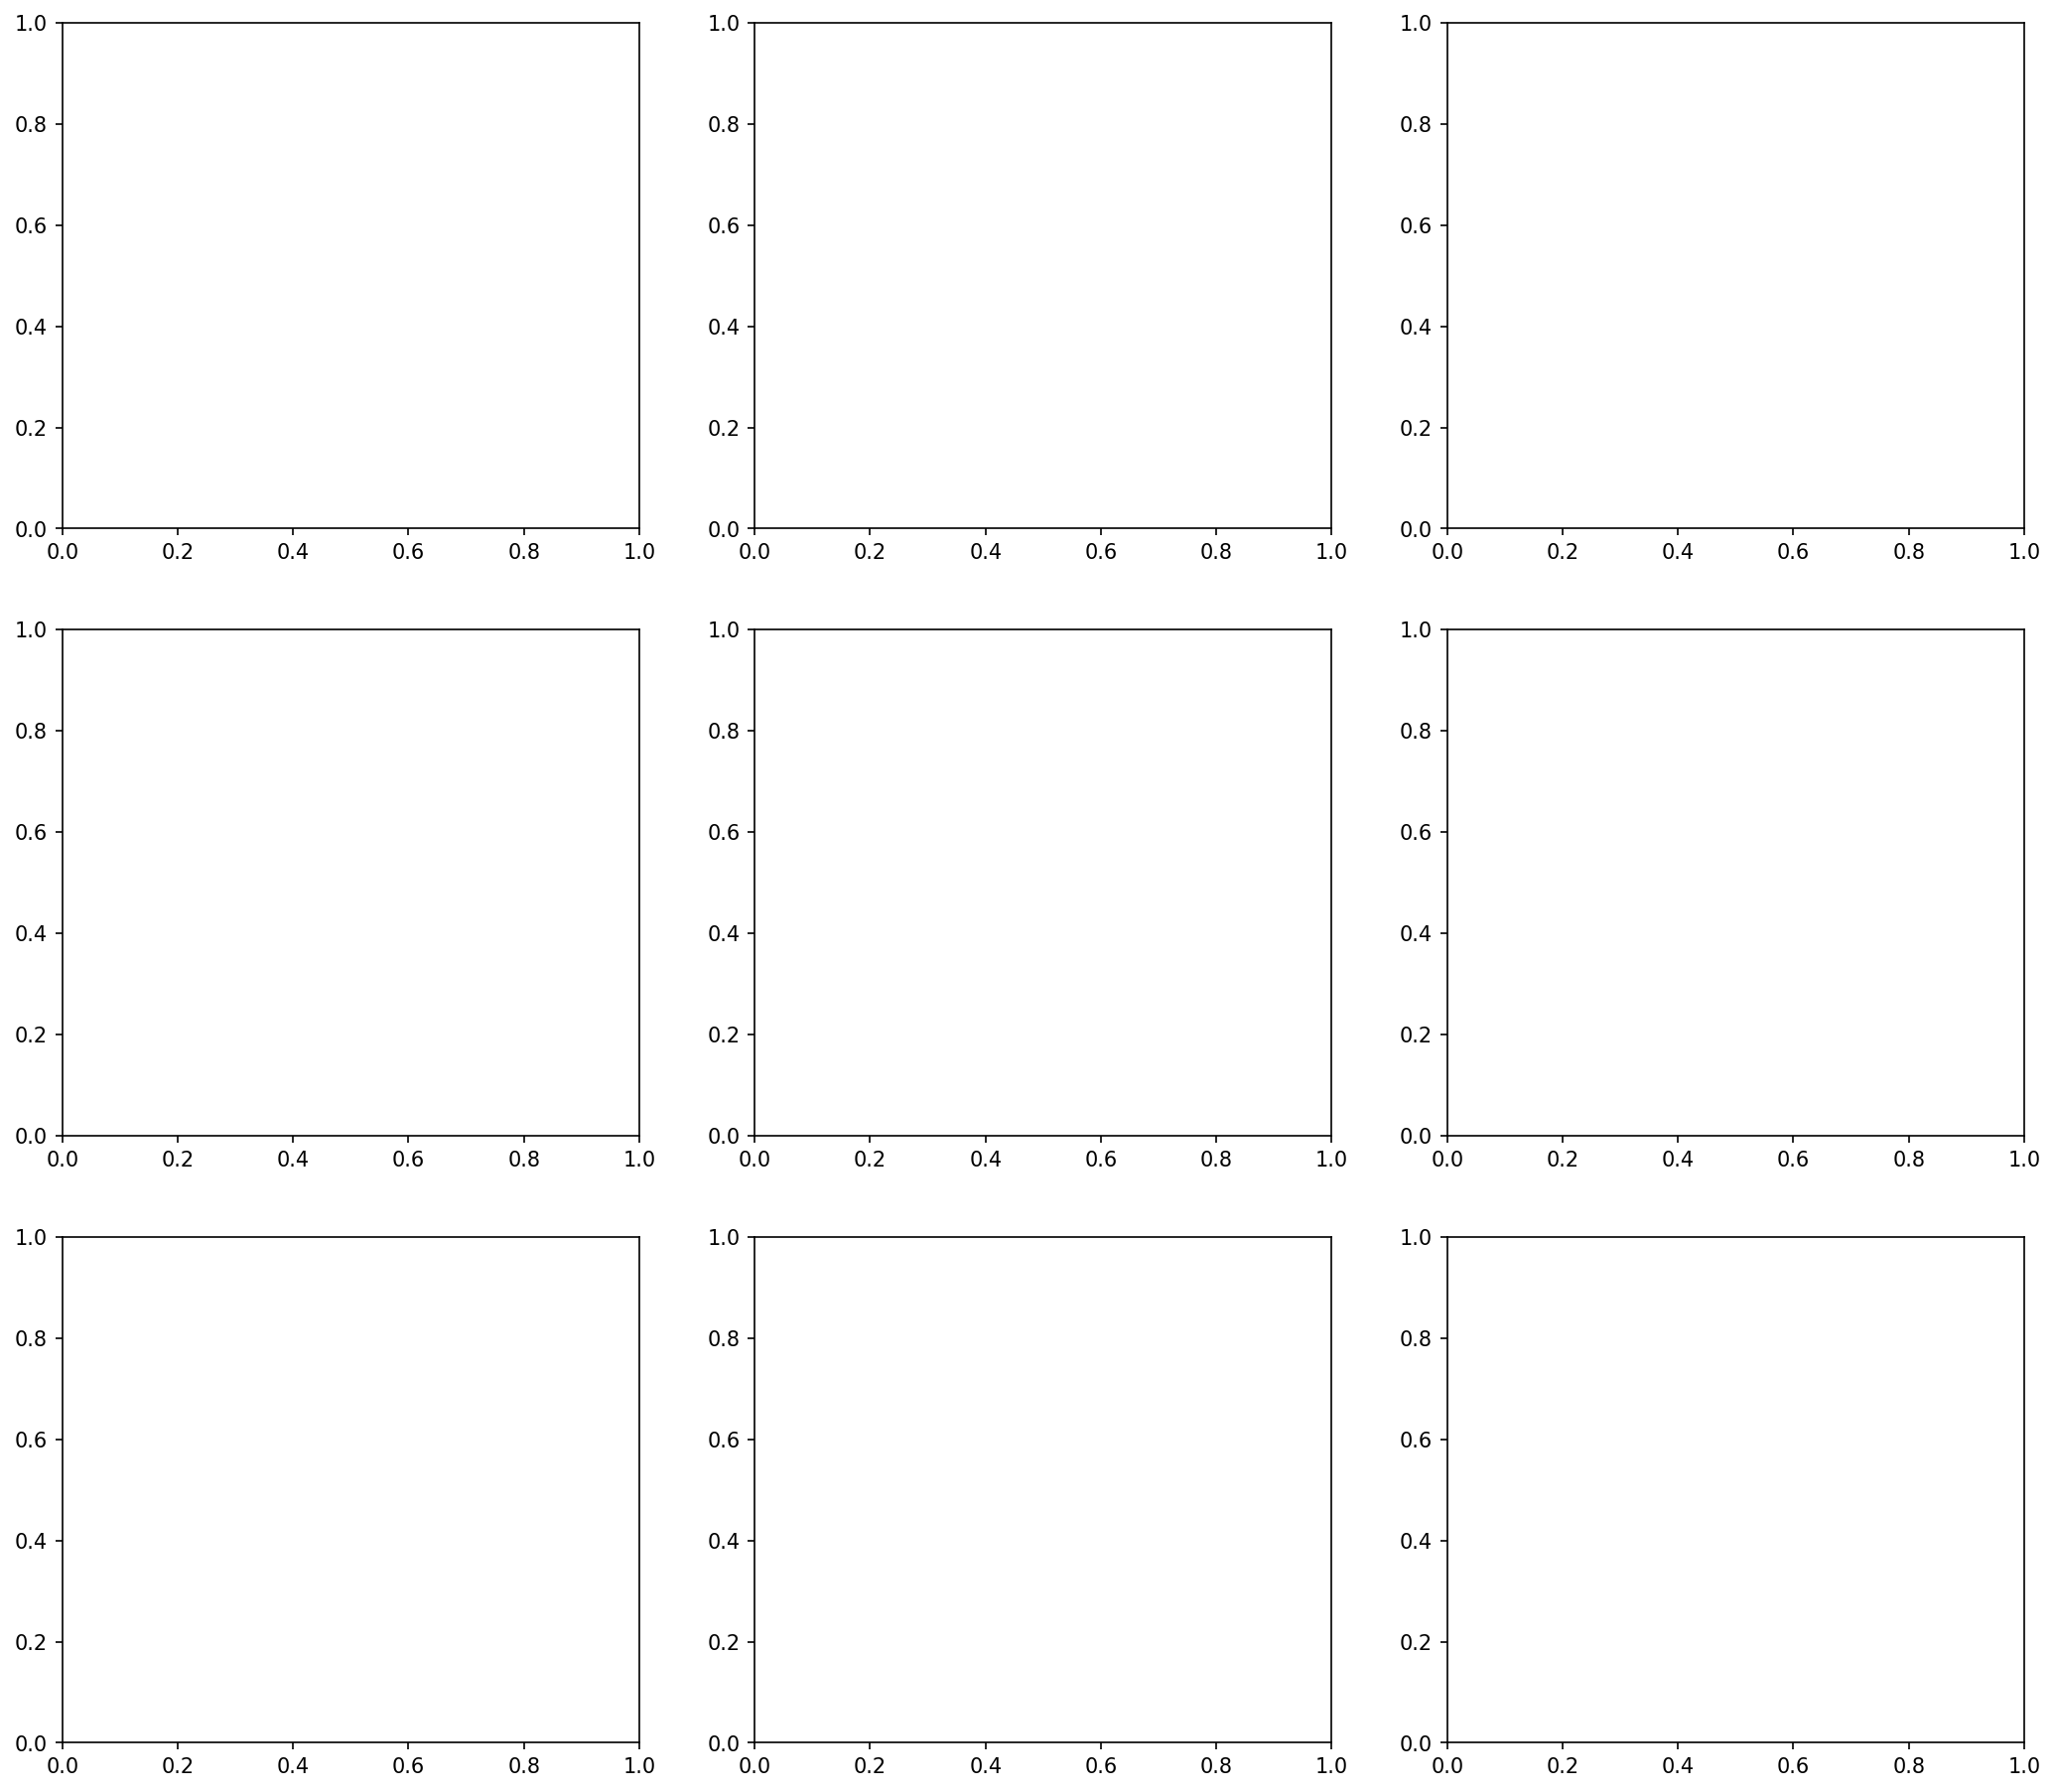

In [14]:
figure_name = "fig_cc_02.svg"

figure = plt.figure(figsize=(17, 15))
grid_spec = figure.add_gridspec(nrows=3, 
                                ncols=3, 
                                width_ratios=[1, 1, 1], 
                                height_ratios=[1, 1, 1])

axis = []
for i in range(3):
    axis_row = []
    for j in range(3):
        axis_row.append(figure.add_subplot(grid_spec[i, j]))
    axis.append(axis_row)

ixdepth = 2
xdepths = [143, 647, 1033]
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
en_labels = ["1.0-1.3", "2.0-2.5", "4.0-5.0"]


for ixdepth in range(3):
  ax = axis[0][ixdepth] 
  
  icolor = 0
  ienlabel = 0  
  for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
      if i in [0, 2, 4]: # Choose energy ranges to plot
          ax.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                            label = f"Corsika_MTrue {en_labels[ienlabel]} GeV",
                            color = line_colors[icolor],
                            linestyle = "-"
                          )
          icolor += 1
          ienlabel += 1  

  icolor = 0
  ienlabel = 0        
  for i, crs_comb_mu in enumerate(corsika_comb_mu0[ixdepth]):
      if i in [0, 2, 4]: # Choose energy ranges to plot
          ax.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                            label = f"Corsika_MFalse {en_labels[ienlabel]} GeV",
                            color = line_colors[icolor],
                            linestyle = "--"
                          ) 
          icolor += 1
          ienlabel += 1
          
  ax.set_title(f"X={xdepths[ixdepth]}" + r"$g/cm^2$")

  ax.set_xlabel(r"$\theta$, deg")
  ax.set_ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
  # plt.yscale("log")
  # plt.xlim(0.08, 0.1)
  ax.set_ylim(0, 0.032)
  ax.legend(fontsize="10")
  ax.grid()

# Log
for ixdepth in range(3):
  ax = axis[1][ixdepth] 
  
  icolor = 0
  ienlabel = 0  
  for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
      if i in [0, 2, 4]: # Choose energy ranges to plot
          ax.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                            label = f"Corsika_MTrue {en_labels[ienlabel]} GeV",
                            color = line_colors[icolor],
                            linestyle = "-"
                          )
          icolor += 1
          ienlabel += 1  

  icolor = 0
  ienlabel = 0        
  for i, crs_comb_mu in enumerate(corsika_comb_mu0[ixdepth]):
      if i in [0, 2, 4]: # Choose energy ranges to plot
          ax.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                            label = f"Corsika_MFalse {en_labels[ienlabel]} GeV",
                            color = line_colors[icolor],
                            linestyle = "--"
                          ) 
          icolor += 1
          ienlabel += 1
          
  ax.set_title(f"X={xdepths[ixdepth]}" + r"$g/cm^2$")

  ax.set_xlabel(r"$\theta$, deg")
  ax.set_ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
  ax.set_yscale("log")
  # plt.xlim(0.08, 0.1)
  ax.set_ylim(1e-7, 0.032)
  ax.legend(fontsize="10")
  ax.grid()

# Ratio
for ixdepth in range(3):
  ax = axis[2][ixdepth]

  icolor = 0
  ienlabel = 0
  for i, _ in enumerate(corsika_comb_mu[ixdepth]):
      if i in [0, 2, 4]: # Choose energy ranges to plot
          
          crs_comb_mu = corsika_comb_mu[ixdepth][i]
          crs_comb_mu0 = corsika_comb_mu0[ixdepth][i]
          ax.stairs(crs_comb_mu[0]/crs_comb_mu0[0], np.rad2deg(crs_comb_mu[1]), 
                            label = f"Corsika_MTrue/Corsika_MFalse {en_labels[ienlabel]} GeV",
                            color = line_colors[icolor],
                            linestyle = "-"
                          )
          icolor += 1
          ienlabel += 1  
          
          
  ax.set_title(f"X={xdepths[ixdepth]}" + r"$g/cm^2$")

  ax.set_xlabel(r"$\theta$, deg")
  ax.set_ylabel(r"Corsika_MTrue/Corsika_MFalse")
  # plt.yscale("log")
  # plt.xlim(0.08, 0.1)
  ax.set_ylim(0, 2)
  ax.legend(fontsize="10")  
  ax.grid()                 
  
figure.suptitle(r"Corsika_MTrue vs. Corsika_MFalse, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
            r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")  
figure.tight_layout()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
# for xdepth in [143, 647, 1033]:
#     plt.stairs(mceq_hists[13][xdepth]["hist_en_ang"].T[0],
#                 mceq_hists[13][xdepth]["en_bins"], label = f"MCEq, X={xdepth}")
xdepth_list = [143, 647, 1033]

line_colors = []
for ixdepth in range(3):
    
    line = plt.stairs(mceq_hists_en[13][xdepth_list[ixdepth]]["hist_en_ang"].T[0],
            mceq_hists_en[13][xdepth_list[ixdepth]]["en_bins"], 
            label = f"MCEq2D, X={xdepth_list[ixdepth]} " + r"$g/cm^2$",
            # color = line.get_edgecolor(),
                #   linestyle = "--"
                    )
    line_colors.append(line.get_edgecolor())
    
for ixdepth in range(3):    
    fl_hist_en = fluka_hist_en["current"][ixdepth]
    plt.stairs(fl_hist_en[1], fl_hist_en[0], 
                      label = f"Fluka, X={fl_hist_en[3]} " + r"$g/cm^2$",
                      color = line_colors[ixdepth],
                      linestyle = "--")


# Corsika
for ixdepth in range(3):    
    fl_hist_en = corsika_en_dist[ixdepth]
    plt.stairs(fl_hist_en[0], fl_hist_en[1], 
                      label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
                      color = line_colors[ixdepth],
                      linestyle = ":")
    
    # fl_hist_en = corsika_en_dist[ixdepth]
    # plt.stairs(fl_hist_en[0], fl_hist_en[1], 
    #                   label = f"corsika {fl_hist_en[3]} g/cm2",
    #                   color = line.get_edgecolor(),
    #                   linestyle = ":"
    #                   )

plt.xscale("log")
plt.xlim(1e-1, 1e2)
plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(fontsize="8")   
plt.title(r"MCEq2D vs. Fluka(2021) vs. Corsika, $\mu_{-} + \mu_{+}$ energy spectra" + "\n"
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.savefig(dir_for_figures/'fig01_02.png')

In [ ]:
xdepth_list = [143, 647, 1033]

line_colors = []

# Fluka
for ixdepth in range(3):
  cr_hist_en = corsika_en_dist[ixdepth]
  fl_hist_en = fluka_hist_en["current"][ixdepth]
  line = plt.stairs(fl_hist_en[1]/cr_hist_en[0],
              fl_hist_en[0], 
              label = f"Fluka/Corsika, X={xdepth_list[ixdepth]} " + r"$g/cm^2$")
  
  line_colors.append(line.get_edgecolor())
  
# Corsika
# for ixdepth in range(3):    
#     fl_hist_en = corsika_en_dist[ixdepth]
#     plt.stairs(fl_hist_en[0], fl_hist_en[1], 
#                       label = f"Corsika, {fl_hist_en[3]} " + r"$g/cm^2$",
#                       color = line_colors[ixdepth],
#                       linestyle = "--")

plt.xscale("log")
plt.xlim(3e-1, 1e2)
plt.ylim(0.75, 1.5)
# plt.yscale("log")
plt.xlabel("E, GeV")
plt.ylabel(r"$\frac{dN}{dE}\Delta E$ per primary")
plt.legend(fontsize="8")   
plt.title(r"Ratio of Fluka/Corsika of $\mu_{-} + \mu_{+}$ energy spectra" + "\n"
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$")
plt.grid()
plt.savefig(dir_for_figures/'fig01_03.png')

# Anglular distributions

In [ ]:
# Get MCEq histogram
angle_bins = fluka_ang_bins
energy_bins = [1, 1.3, 2, 2.5, 4, 5]
mceq_hists_ang = mceq_dists.histograms(energy_bins, angle_bins)

In [ ]:
xdepth = 143
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/'fig10.png')

In [ ]:
xdepth = 143
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/'fig11.png')

In [ ]:
xdepth = 143
ixdepth = 0
line_colors = []
ienergy = 0
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Fluka/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
# for ixdepth in range(3):
#     for ienergy in range(3):
#         if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
#             fl_dist = fluka_hist["current"][ixdepth][ienergy]
#             line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
#                     label = f"current: {fl_dist[4]} GeV",
#                     color = line_colors[ienergy],
#                     linestyle = "--")      
        
        
plt.title(r"Ratio Fluka/MCEq2D of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0.3, 1.2)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/'fig12.png')

In [ ]:
xdepth = 647
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [1]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/'fig13.png')

In [ ]:
xdepth = 647
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [1]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/'fig14.png')

In [ ]:
figure_name = "fig15.png"
xdepth = 647
ixdepth = 1
line_colors = []
ienergy = 0
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Fluka/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
# for ixdepth in range(3):
#     for ienergy in range(3):
#         if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
#             fl_dist = fluka_hist["current"][ixdepth][ienergy]
#             line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
#                     label = f"current: {fl_dist[4]} GeV",
#                     color = line_colors[ienergy],
#                     linestyle = "--")      
        
        
plt.title(r"Ratio Fluka/MCEq2D of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0.1, 1.2)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig16.png"
xdepth = 1033
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [2]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig17.png"
xdepth = 1033
line_colors = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [2]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")      
        
        
plt.title(r"Fluka vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig18.png"
xdepth = 1033
ixdepth = 2
line_colors = []
ienergy = 0
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Fluka/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        
        
# for ixdepth in range(3):
#     for ienergy in range(3):
#         if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
#             fl_dist = fluka_hist["current"][ixdepth][ienergy]
#             line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
#                     label = f"current: {fl_dist[4]} GeV",
#                     color = line_colors[ienergy],
#                     linestyle = "--")      
        
        
plt.title(r"Ratio Fluka/MCEq2D of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0, 1.2)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/figure_name)

# Corsika vs Fluka

In [ ]:
figure_name = "fig02_01.png"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig02_02.png"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig02_03.png"
xdepth = 143
ixdepth = 0
line_colors = []
ienergy = 0

for ind_energy, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/crs_comb_mu[0],
                    np.rad2deg(crs_comb_mu[1]),
                    label = f"Fluka/Corsika {en_label} GeV")
        line_colors.append(line.get_edgecolor())  
        
        
plt.title(r"Ratio Fluka/Corsika of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0, 1.5)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig02_04.png"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig02_05.png"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig02_06.png"
xdepth = 647
ixdepth = 1
line_colors = []
ienergy = 0

for ind_energy, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/crs_comb_mu[0],
                    np.rad2deg(crs_comb_mu[1]),
                    label = f"Fluka/Corsika {en_label} GeV")
        line_colors.append(line.get_edgecolor())  
        
        
plt.title(r"Ratio Fluka/Corsika of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0, 1.5)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig02_07.png"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig02_08.png"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        # line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
        #             np.rad2deg(mceq_plt["ang_bins"]),
        #             label = f"MCEq {en_label} GeV")
        # line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                        #   color = line_colors[icolor],
                        #   linestyle = "--"
                        )
        
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        icolor += 1
        ienlabel += 1  
        
for ixdepth in range(3):
    for ienergy in range(3):
        if (ienergy in [0, 1, 2]) and (ixdepth in [0]):
            fl_dist = fluka_hist["current"][ixdepth][ienergy]
            line = plt.stairs(fl_dist[1], np.rad2deg(fl_dist[0]),
                    label = f"Fluka {fl_dist[4]} GeV",
                    color = line_colors[ienergy],
                    linestyle = "--")          
          
        
        
plt.title(r"Corsika vs. Fluka, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig02_09.png"
xdepth = 1033
ixdepth = 2
line_colors = []
ienergy = 0

for ind_energy, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        
        fl_dist = fluka_hist["current"][ixdepth][ienergy]
        ienergy += 1
        line = plt.stairs(fl_dist[1]/crs_comb_mu[0],
                    np.rad2deg(crs_comb_mu[1]),
                    label = f"Fluka/Corsika {en_label} GeV")
        line_colors.append(line.get_edgecolor())  
        
        
plt.title(r"Ratio Fluka/Corsika of $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Fluka/MCEq")
# plt.yscale("log")
plt.xlim(0, 20)
plt.ylim(0, 1.5)
plt.grid()
plt.legend(fontsize="8", loc = "best")  
plt.savefig(dir_for_figures/figure_name)

# Corsika vs MCEq with fluka bins

In [ ]:
figure_name = "fig19.png"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig20.png"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig21.png"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig22.png"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig23.png"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig24.png"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig25.png"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig26.png"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig27.png"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_en[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
# plt.xlim(0.08, 0.1)
# plt.ylim(20, 25)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

# Corsika vs MCEq2D

In [ ]:
# Get MCEq histogram
# angle_bins = fluka_ang_bins
angle_bins = np.deg2rad(np.linspace(0, 90, 91))
energy_bins = [1, 1.3, 2, 2.5, 4, 5]
mceq_hists_ang1 = mceq_dists.histograms(energy_bins, angle_bins)

In [ ]:
energy_bins = [1, 1.3, 2, 2.5, 4, 5]
angle_bins = np.deg2rad(np.linspace(0, 90, 91))
corsika_en_hist1 = corsika_en_theta_2dhist(energy_bins, 
                                          angle_bins,
                                          h5file=corsika_data_file)

corsika_comb_mu1 = combined_ang_data(corsika_en_hist1, (-13, 13))
corsika_comb_nue1 = combined_ang_data(corsika_en_hist1, (-12, 12))
corsika_comb_numu1 = combined_ang_data(corsika_en_hist1, (-14, 14))

In [ ]:
figure_name = "fig28.png"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig29.png"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig30.png"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu1[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
plt.xlim(0, 30)
plt.ylim(0, 3)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig31.png"
xdepth = 143
ixdepth = 0
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu1[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
plt.xlim(0, 30)
plt.ylim(0.5, 1.2)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig32.png"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig33.png"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig34.png"
xdepth = 647
ixdepth = 1
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu1[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
plt.xlim(0, 30)
plt.ylim(0, 1.5)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig35.png"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
# plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig36.png"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)

icolor = 0
ienlabel = 0
for i, crs_comb_mu in enumerate(corsika_comb_mu1[ixdepth]):
    if i in [0, 2, 4]: # Choose energy ranges to plot
        line = plt.stairs(crs_comb_mu[0], np.rad2deg(crs_comb_mu[1]), 
                          label = f"Corsika {en_labels[ienlabel]} GeV",
                          color = line_colors[icolor],
                          linestyle = "--")
        icolor += 1
        ienlabel += 1  
          
        
        
plt.title(r"Corsika vs. MCEq2D, $\mu_{-} + \mu_{+}$ angular distribution" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"$\frac{dN}{dEd\Omega}\Delta E\Delta \Omega$ per primary")
plt.yscale("log")
plt.xlim(0, 30)
# plt.ylim(20, 25)
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)

In [ ]:
figure_name = "fig37.png"
xdepth = 1033
ixdepth = 2
line_colors = []
en_labels = []
for ind_energy, en1 in enumerate(mceq_hists_ang1[13][xdepth]["en_bins"]):
    if ind_energy in [0, 2, 4]:
        mceq_plt = mceq_hists_ang1[13][xdepth]
        en_range = mceq_plt["en_bins"][ind_energy:ind_energy +2]
        en_label = f"{en_range[0]:0.1f}-{en_range[1]:0.1f}"
        line = plt.stairs(corsika_comb_mu1[ixdepth][ind_energy][0]/mceq_plt["hist_en_ang"][ind_energy],
                    np.rad2deg(mceq_plt["ang_bins"]),
                    label = f"Corsika/MCEq {en_label} GeV")
        line_colors.append(line.get_edgecolor())
        en_labels.append(en_label)
        
        
plt.title(r"Ratio of Corsika/MCEq2D, $\mu_{-} + \mu_{+}$ angular distributions" + "\n" +
          r"$E_{0}=100$ GeV, $\theta=30^{\circ}$" + f", X={xdepth}" + r"$g/cm^2$")
plt.xlabel(r"$\theta$, deg")
plt.ylabel(r"Corsika/MCEq2D")
# plt.yscale("log")
plt.xlim(0, 30)
plt.ylim(0, 1.5)
plt.grid()
plt.legend(fontsize="8")  
plt.legend()
plt.savefig(dir_for_figures/figure_name)